In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adinda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adinda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Adinda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [25]:
df = pd.read_csv('IMDB Dataset.csv')

# EDA (Exploratory Data Analysis)

## Cek Missing Values

In [26]:
print("=== Pengecekan Missing Values ===")
missing_values = df.isnull().sum()
print("Jumlah missing values:")
print(missing_values)

=== Pengecekan Missing Values ===
Jumlah missing values:
review       0
sentiment    0
dtype: int64


## Cek Duplikasi

In [27]:
print("\n=== Pengecekan Duplikasi ===")
duplicate_rows = df.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_rows}")
if duplicate_rows > 0:
    print("\nContoh baris duplikat:")
    print(df[df.duplicated()].head())
print(f"\nDeskripsi: {duplicate_rows} baris duplikat ditemukan.")
print(f"\nJumlah baris awal: {len(df)}")


=== Pengecekan Duplikasi ===
Jumlah baris duplikat: 418

Contoh baris duplikat:
                                                 review sentiment
3537  Quite what the producers of this appalling ada...  negative
3769  My favourite police series of all time turns t...  positive
4391  Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352  If you liked the Grinch movie... go watch that...  negative
6479  I want very much to believe that the above quo...  negative

Deskripsi: 418 baris duplikat ditemukan.

Jumlah baris awal: 50000


## Cek Distribusi Label Sentimen


=== Distribusi Label Sentimen ===
Jumlah ulasan per sentimen:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Statistik Deskriptif Sentimen:
count        2.0
mean     25000.0
std          0.0
min      25000.0
25%      25000.0
50%      25000.0
75%      25000.0
max      25000.0
Name: count, dtype: float64


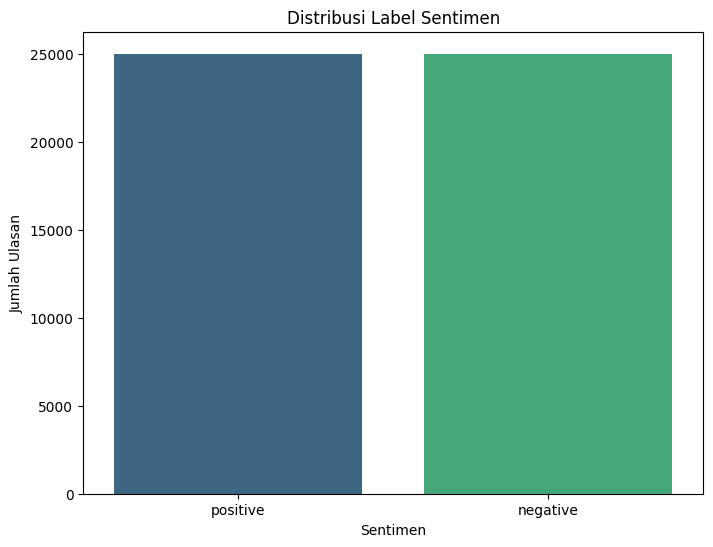

In [28]:
print("\n=== Distribusi Label Sentimen ===")
sentiment_counts = df['sentiment'].value_counts()
print("Jumlah ulasan per sentimen:")
print(sentiment_counts)
print("\nStatistik Deskriptif Sentimen:")
print(sentiment_counts.describe())

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='viridis')
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

## Cek Panjang Teks (Jumlah Kata)


=== Statistik Deskriptif Panjang Teks (Jumlah Kata) ===
count    50000.000000
mean       279.483720
std        207.949849
min          8.000000
25%        151.000000
50%        209.000000
75%        340.000000
max       2911.000000
Name: word_count, dtype: float64


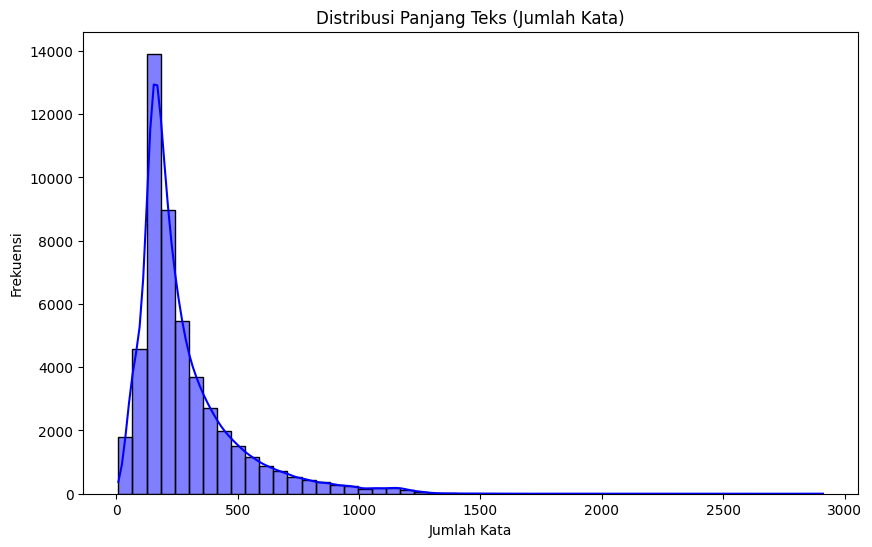

In [29]:
df['word_count'] = df['review'].apply(lambda x: len(word_tokenize(x)))
print("\n=== Statistik Deskriptif Panjang Teks (Jumlah Kata) ===")
print(df['word_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='blue')
plt.title('Distribusi Panjang Teks (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

## Melihat 10 Kata Paling Umum


=== 10 Kata Paling Umum (Setelah Menghapus Stopwords) ===
br        201951
movie      85070
film       76919
one        51828
like       39183
good       28767
would      26475
even       24780
time       23481
really     23024
dtype: int64


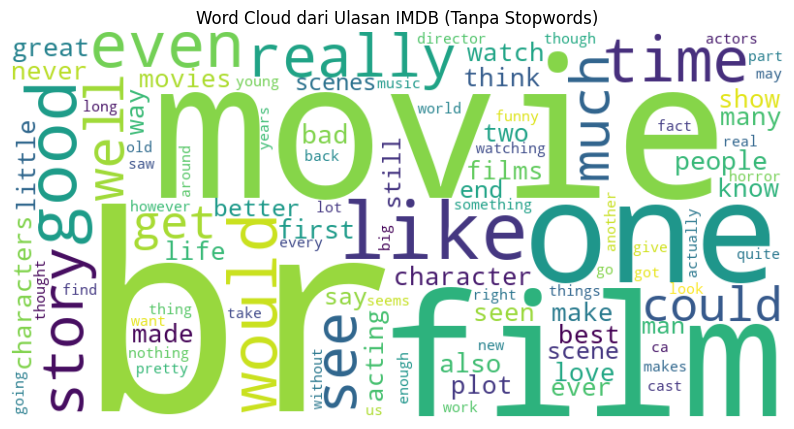

In [30]:
stop_words = set(stopwords.words('english'))
all_text = ' '.join(df['review'].values).lower()
tokens = [word for word in word_tokenize(all_text) if word.isalpha() and word not in stop_words]
word_freq = Counter(tokens)

print("\n=== 10 Kata Paling Umum (Setelah Menghapus Stopwords) ===")
top_words = pd.Series(word_freq).sort_values(ascending=False).head(10)
print(top_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, stopwords=stop_words).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Ulasan IMDB (Tanpa Stopwords)')
plt.show()

# Preprocessing

## Menghapus Duplikat


Jumlah baris awal: 50000

=== Distribusi Label Sentimen Sebelum Penghapusan Duplikat ===
Jumlah ulasan per sentimen:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Statistik Deskriptif Sentimen:
count        2.0
mean     25000.0
std          0.0
min      25000.0
25%      25000.0
50%      25000.0
75%      25000.0
max      25000.0
Name: count, dtype: float64


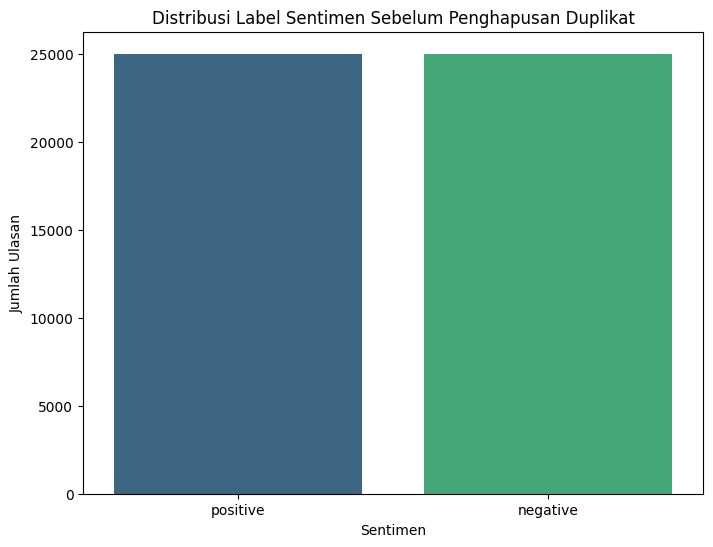


Jumlah baris setelah penghapusan duplikat: 49582

=== Distribusi Label Sentimen Setelah Penghapusan Duplikat ===
Jumlah ulasan per sentimen:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Statistik Deskriptif Sentimen:
count        2.000000
mean     24791.000000
std        131.521861
min      24698.000000
25%      24744.500000
50%      24791.000000
75%      24837.500000
max      24884.000000
Name: count, dtype: float64


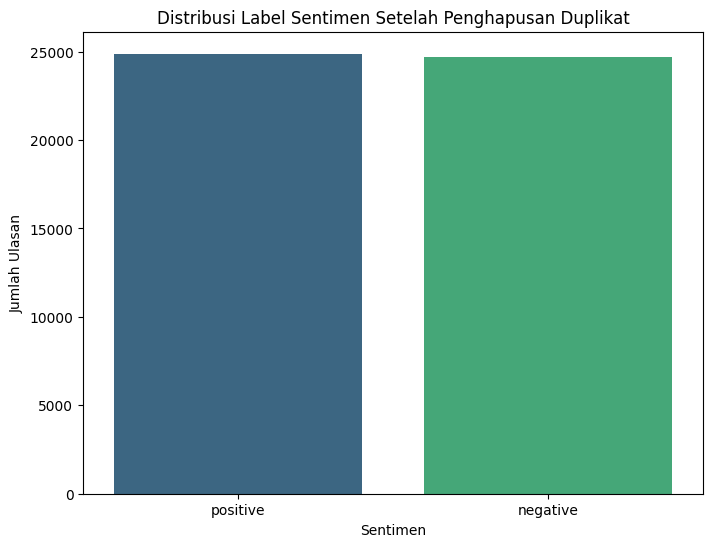

In [31]:
print(f"\nJumlah baris awal: {len(df)}")

print("\n=== Distribusi Label Sentimen Sebelum Penghapusan Duplikat ===")
sentiment_counts = df['sentiment'].value_counts()
print("Jumlah ulasan per sentimen:")
print(sentiment_counts)
print("\nStatistik Deskriptif Sentimen:")
print(sentiment_counts.describe())

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='viridis')
plt.title('Distribusi Label Sentimen Sebelum Penghapusan Duplikat')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

df = df.drop_duplicates(keep='first')
print(f"\nJumlah baris setelah penghapusan duplikat: {len(df)}")

# Distribusi Label Sentimen Setelah Penghapusan Duplikat
print("\n=== Distribusi Label Sentimen Setelah Penghapusan Duplikat ===")
sentiment_counts = df['sentiment'].value_counts()
print("Jumlah ulasan per sentimen:")
print(sentiment_counts)
print("\nStatistik Deskriptif Sentimen:")
print(sentiment_counts.describe())

# Visualisasi distribusi sentimen Setelah Penghapusan Duplikat
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='viridis')
plt.title('Distribusi Label Sentimen Setelah Penghapusan Duplikat')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

## Pembersihan Teks

In [32]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['review_cleaned'] = df['review'].apply(clean_text)
print("\nContoh teks sebelum dan sesudah pembersihan:")
print(f"Sebelum: {df['review'].iloc[0][:50]}...")
print(f"Sesudah: {df['review_cleaned'].iloc[0][:50]}...")


Contoh teks sebelum dan sesudah pembersihan:
Sebelum: One of the other reviewers has mentioned that afte...
Sesudah: one of the other reviewers has mentioned that afte...


## Normalisasi Panjang Teks (Jumlah Kata)


=== Statistik Deskriptif Panjang Teks (Jumlah Kata) Sebelum Normalisasi ===
count    49582.000000
mean       279.711468
std        208.167256
min          8.000000
25%        151.000000
50%        209.000000
75%        340.000000
max       2911.000000
Name: word_count, dtype: float64


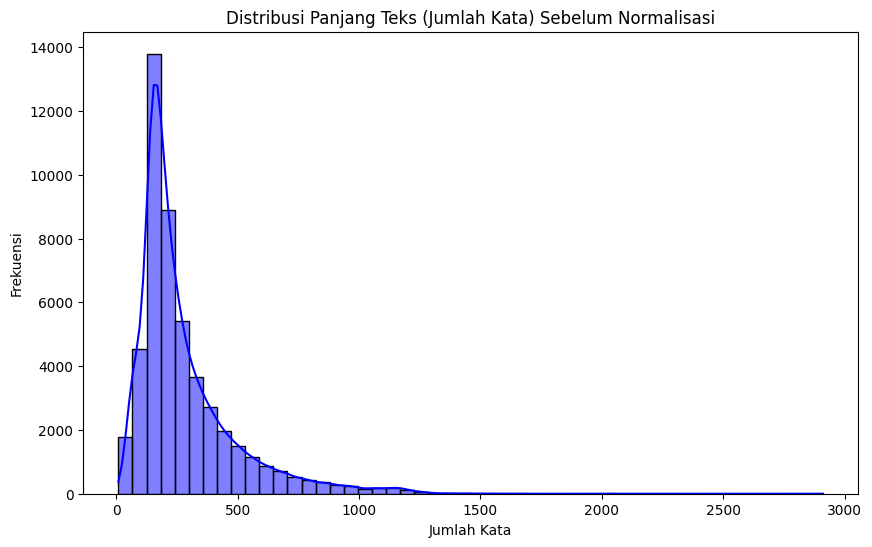


Statistik Deskriptif Panjang Teks Setelah Normalisasi:
count    49582.000000
mean       225.445585
std        167.168504
min          4.000000
25%        124.000000
50%        169.000000
75%        273.000000
max       2441.000000
Name: word_count_cleaned, dtype: float64


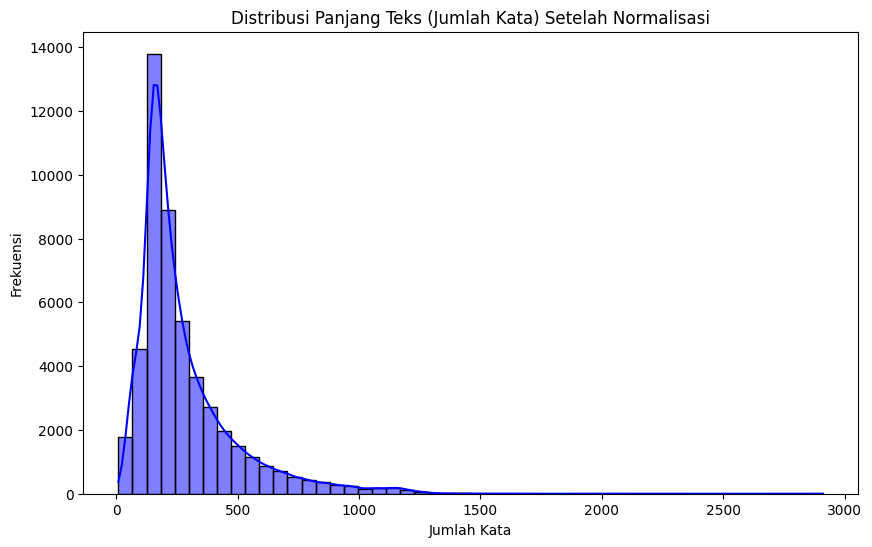

In [33]:
df['word_count'] = df['review'].apply(lambda x: len(word_tokenize(x)))
print("\n=== Statistik Deskriptif Panjang Teks (Jumlah Kata) Sebelum Normalisasi ===")
print(df['word_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='blue')
plt.title('Distribusi Panjang Teks (Jumlah Kata) Sebelum Normalisasi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

max_length = 512  # Berdasarkan statistik panjang teks (mean ~279, max 2911)
df['word_count_cleaned'] = df['review_cleaned'].apply(lambda x: len(word_tokenize(x)))
df['review_truncated'] = df['review_cleaned'].apply(
    lambda x: ' '.join(word_tokenize(x)[:max_length]) if len(word_tokenize(x)) > max_length else x
)
print("\nStatistik Deskriptif Panjang Teks Setelah Normalisasi:")
print(df['word_count_cleaned'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='blue')
plt.title('Distribusi Panjang Teks (Jumlah Kata) Setelah Normalisasi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

## Tokenisasi

In [34]:
df['tokens'] = df['review_truncated'].apply(lambda x: word_tokenize(x))
print("\nContoh Tokenisasi Manual:")
print(f"Contoh ulasan: {df['review_truncated'].iloc[0][:50]}...")
print(f"Token: {df['tokens'].iloc[0][:10]}")


Contoh Tokenisasi Manual:
Contoh ulasan: one of the other reviewers has mentioned that afte...
Token: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']


## Menghapus Stopwords

In [35]:
stop_words = set(stopwords.words('english'))
df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
print("\nContoh Token Setelah Menghapus Stopwords:")
print(f"Token asli: {df['tokens'].iloc[0][:10]}")
print(f"Token tanpa stopwords: {df['tokens_no_stopwords'].iloc[0][:10]}")


Contoh Token Setelah Menghapus Stopwords:
Token asli: ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']
Token tanpa stopwords: ['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly']


# Modeling (IBM Granite)

Model Transformer Encoder manual yang menyerupai IBM Granite, dioptimalkan untuk laptop karena keterbatasan akses ke WatsonX (tidak memiliki kartu kredit).

1. Vaswani, A., et al. (2017). "Attention is All You Need." *Advances in Neural Information Processing Systems (NeurIPS)*, 30. [https://arxiv.org/abs/1706.03762]

2. Devlin, J., et al. (2019). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding." *Proceedings of NAACL-HLT*. [https://arxiv.org/abs/1810.04805]

3. Sun, C., et al. (2019). "How to Fine-Tune BERT for Text Classification?" *arXiv preprint*. [https://arxiv.org/abs/1905.05583]

## Persiapan Modeling

In [ ]:
vocab = {word: idx for idx, word in enumerate(set(word for tokens in df['tokens_no_stopwords'] for word in tokens))}
df['token_indices'] = df['tokens_no_stopwords'].apply(lambda x: [vocab.get(word, 0) for word in x])

max_seq_length = 256
X = np.array([seq[:max_seq_length] + [0] * (max_seq_length - len(seq)) for seq in df['token_indices'].values])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

batch_size = 64
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

embed_dim = 16
num_heads = 2
num_layers = 1
d_ff = 32
dropout_rate = 0.1
vocab_size = len(vocab)

pos_enc = np.zeros((max_seq_length, embed_dim))
for pos in range(max_seq_length):
    for i in range(0, embed_dim, 2):
        div_term = 10000 ** (i / embed_dim)
        pos_enc[pos, i] = np.sin(pos / div_term)
        if i + 1 < embed_dim:
            pos_enc[pos, i + 1] = np.cos(pos / div_term)
pos_enc = torch.tensor(pos_enc, dtype=torch.float32)

## Build Model IBM Granite

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, d_ff, num_layers, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim, 
                nhead=num_heads, 
                dim_feedforward=d_ff, 
                dropout=dropout_rate, 
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, 2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x) + pos_enc.to(x.device)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoder(vocab_size, embed_dim, num_heads, d_ff, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train Model

In [ ]:
fold_metrics = []
fold_losses = {fold: [] for fold in range(n_splits)}

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model.train()
    for epoch in range(10):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        fold_losses[fold].append(avg_loss)
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(y_batch.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')
    f1 = f1_score(true_labels, predictions, average='binary')
    roc_auc = roc_auc_score(true_labels, predictions)
    fold_metrics.append({
        'fold': fold + 1, 'epoch': epoch + 1, 'accuracy': accuracy,
        'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc
    })
    print(f"Fold {fold + 1}, Epoch {epoch + 1} Metrics - Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

Fold 1, Epoch 1, Average Loss: 0.5785
Fold 1, Epoch 2, Average Loss: 0.3660
Fold 1, Epoch 3, Average Loss: 0.2865
Fold 1, Epoch 4, Average Loss: 0.2339
Fold 1, Epoch 5, Average Loss: 0.1952
Fold 1, Epoch 6, Average Loss: 0.1625
Fold 1, Epoch 7, Average Loss: 0.1341
Fold 1, Epoch 8, Average Loss: 0.1082
Fold 1, Epoch 9, Average Loss: 0.0857
Fold 1, Epoch 10, Average Loss: 0.0655
Fold 1, Epoch 10 Metrics - Accuracy: 0.8653, Precision: 0.8777, Recall: 0.8479, F1: 0.8626, ROC-AUC: 0.8652
Fold 2, Epoch 1, Average Loss: 0.0938
Fold 2, Epoch 2, Average Loss: 0.0688
Fold 2, Epoch 3, Average Loss: 0.0509
Fold 2, Epoch 4, Average Loss: 0.0381
Fold 2, Epoch 5, Average Loss: 0.0281
Fold 2, Epoch 6, Average Loss: 0.0211
Fold 2, Epoch 7, Average Loss: 0.0146
Fold 2, Epoch 8, Average Loss: 0.0114
Fold 2, Epoch 9, Average Loss: 0.0077
Fold 2, Epoch 10, Average Loss: 0.0061
Fold 2, Epoch 10 Metrics - Accuracy: 0.9667, Precision: 0.9661, Recall: 0.9681, F1: 0.9671, ROC-AUC: 0.9667
Fold 3, Epoch 1, Avera

# Evaluasi Model

Fold 1 Train Confusion Matrix:
[[22211     0]
 [    0 22412]]
Fold 1 Test Confusion Matrix:
[[2487    0]
 [   0 2472]]
Fold 1 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22211
    Positive       1.00      1.00      1.00     22412

    accuracy                           1.00     44623
   macro avg       1.00      1.00      1.00     44623
weighted avg       1.00      1.00      1.00     44623

Fold 1 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2487
    Positive       1.00      1.00      1.00      2472

    accuracy                           1.00      4959
   macro avg       1.00      1.00      1.00      4959
weighted avg       1.00      1.00      1.00      4959



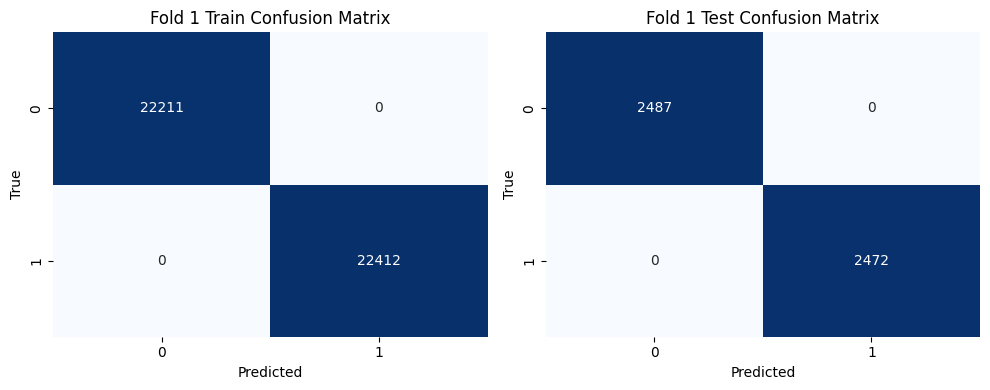

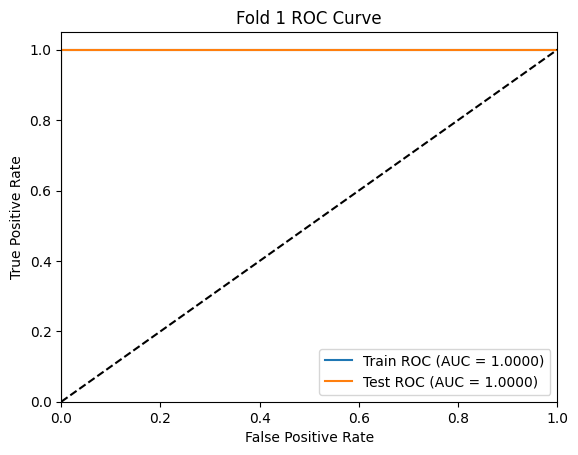

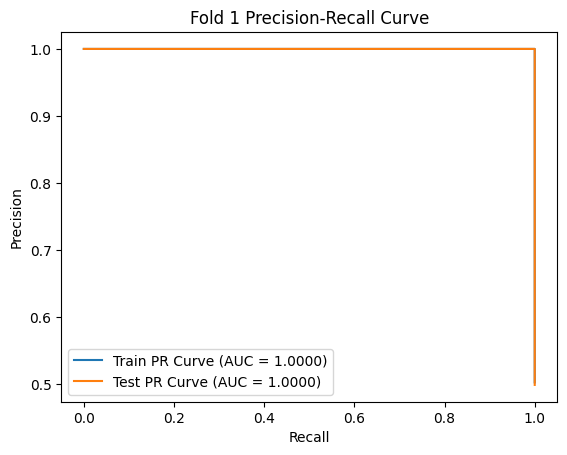

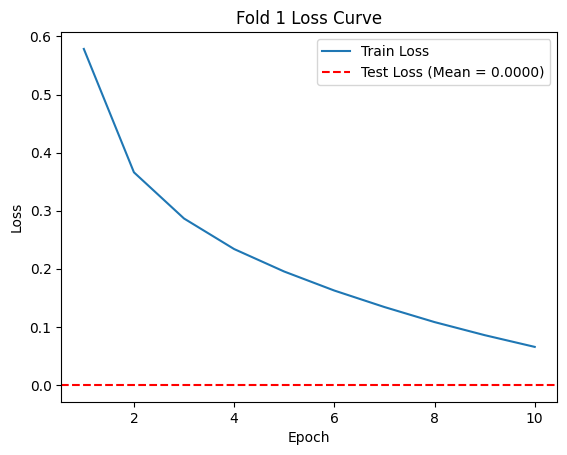

Fold 2 Train Confusion Matrix:
[[22245     0]
 [    0 22378]]
Fold 2 Test Confusion Matrix:
[[2453    0]
 [   0 2506]]
Fold 2 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22245
    Positive       1.00      1.00      1.00     22378

    accuracy                           1.00     44623
   macro avg       1.00      1.00      1.00     44623
weighted avg       1.00      1.00      1.00     44623

Fold 2 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2453
    Positive       1.00      1.00      1.00      2506

    accuracy                           1.00      4959
   macro avg       1.00      1.00      1.00      4959
weighted avg       1.00      1.00      1.00      4959



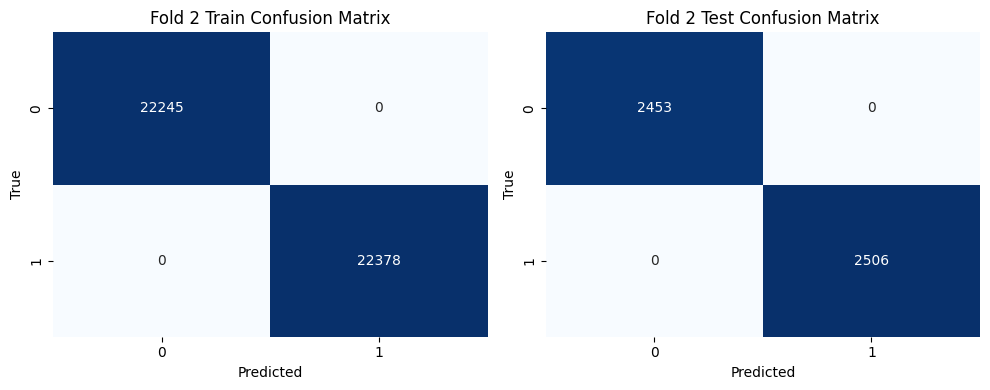

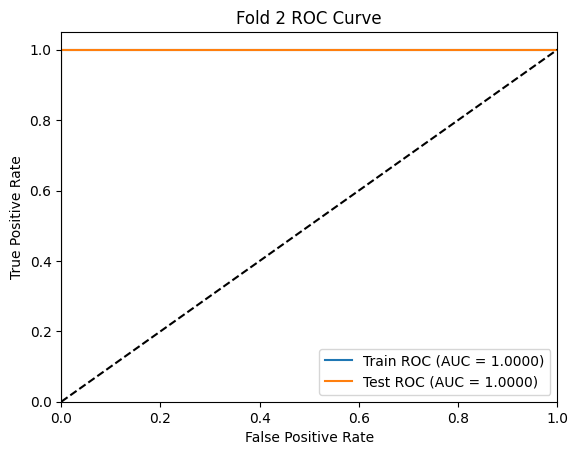

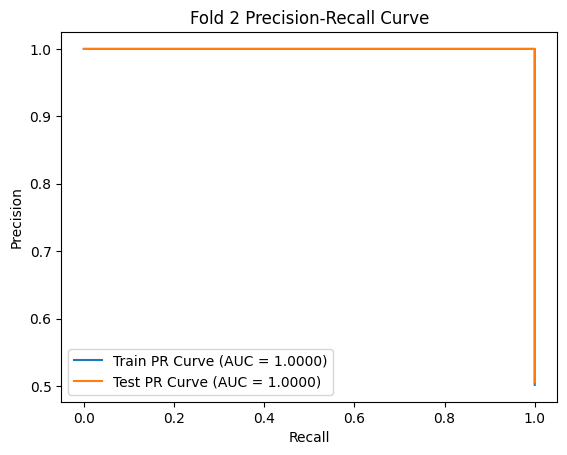

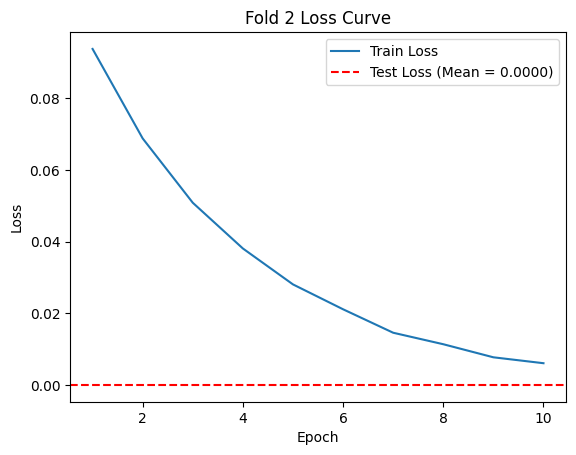

Fold 3 Train Confusion Matrix:
[[22233     0]
 [    0 22391]]
Fold 3 Test Confusion Matrix:
[[2465    0]
 [   0 2493]]
Fold 3 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22233
    Positive       1.00      1.00      1.00     22391

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 3 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2465
    Positive       1.00      1.00      1.00      2493

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



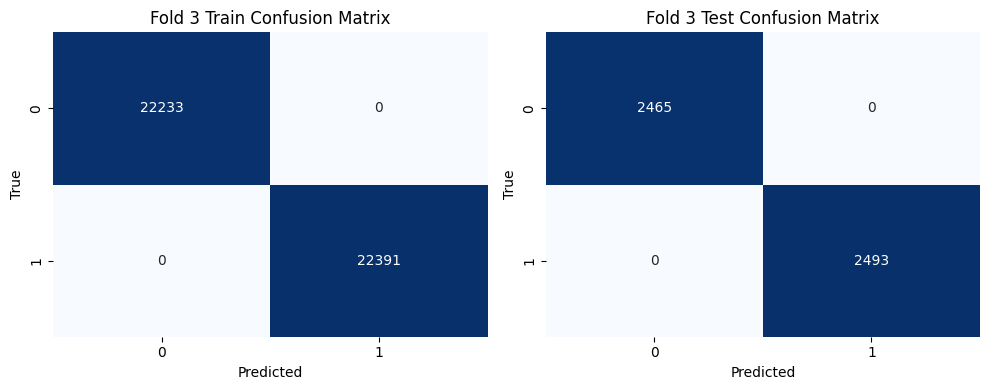

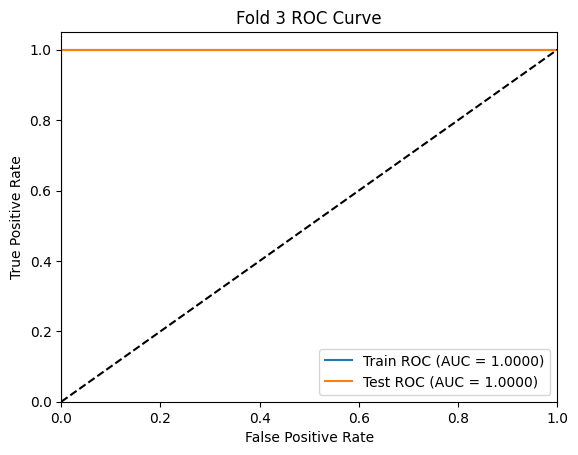

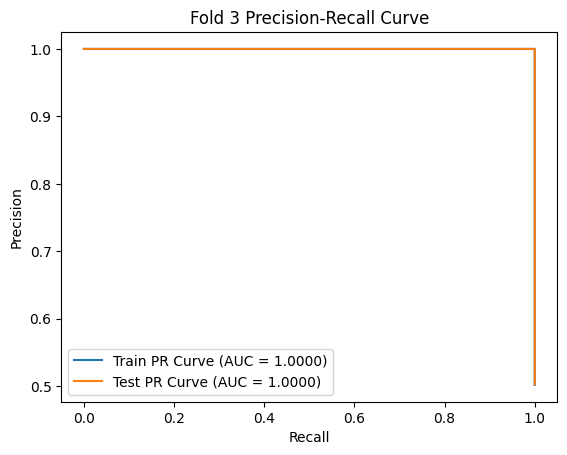

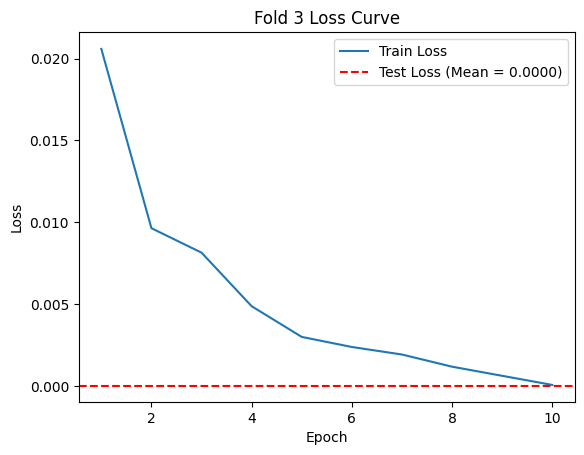

Fold 4 Train Confusion Matrix:
[[22192     0]
 [    0 22432]]
Fold 4 Test Confusion Matrix:
[[2506    0]
 [   0 2452]]
Fold 4 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22192
    Positive       1.00      1.00      1.00     22432

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 4 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2506
    Positive       1.00      1.00      1.00      2452

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



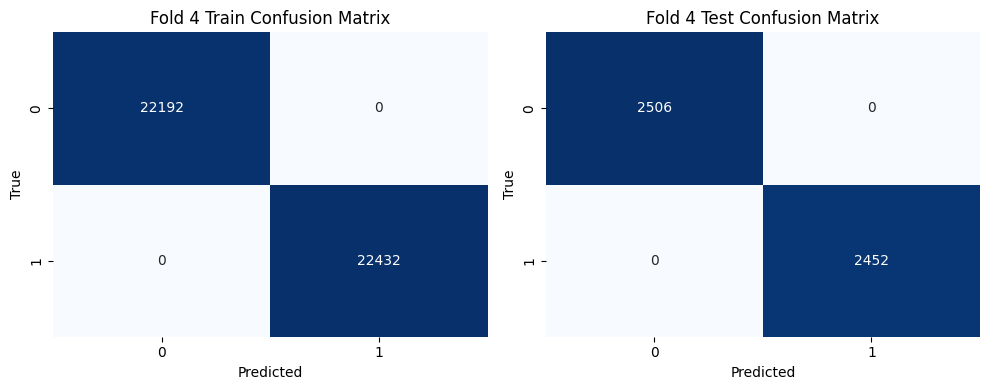

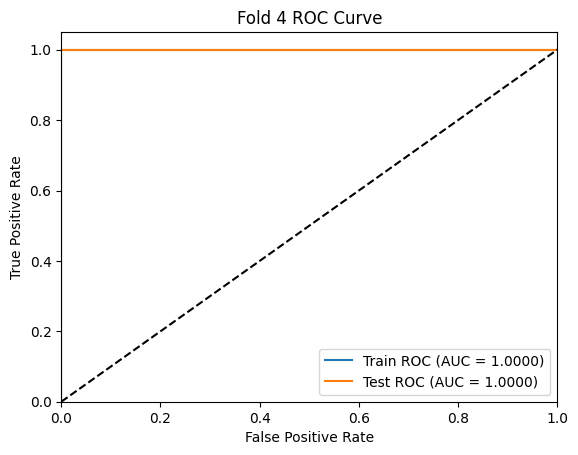

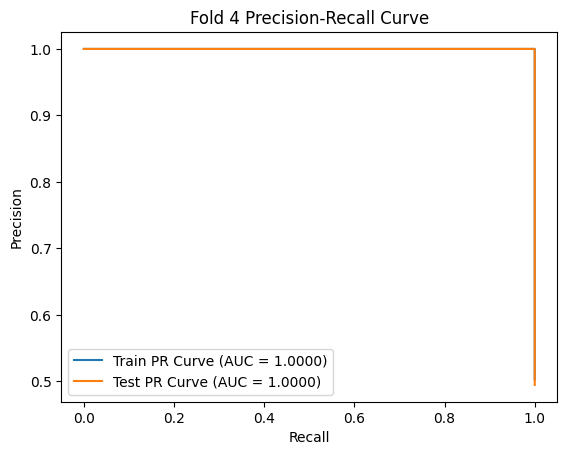

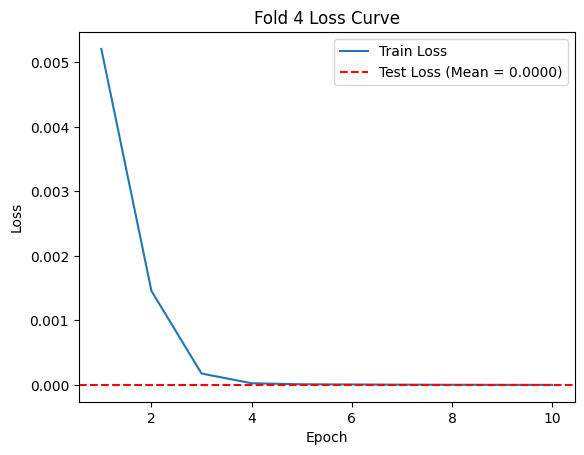

Fold 5 Train Confusion Matrix:
[[22293     0]
 [    0 22331]]
Fold 5 Test Confusion Matrix:
[[2405    0]
 [   0 2553]]
Fold 5 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22293
    Positive       1.00      1.00      1.00     22331

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 5 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2405
    Positive       1.00      1.00      1.00      2553

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



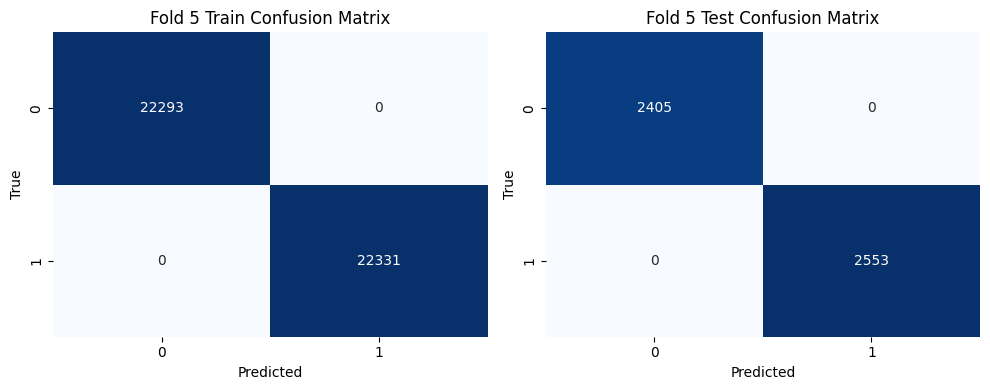

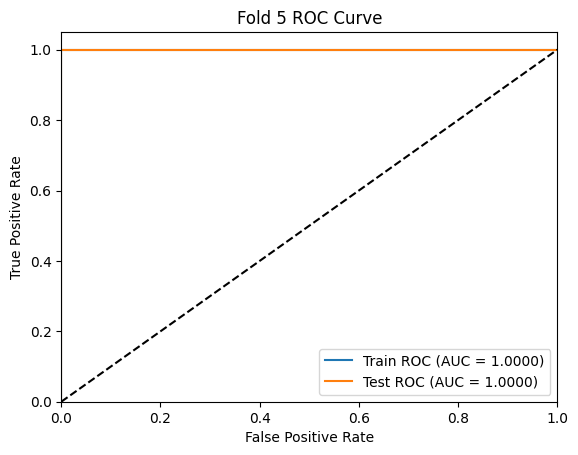

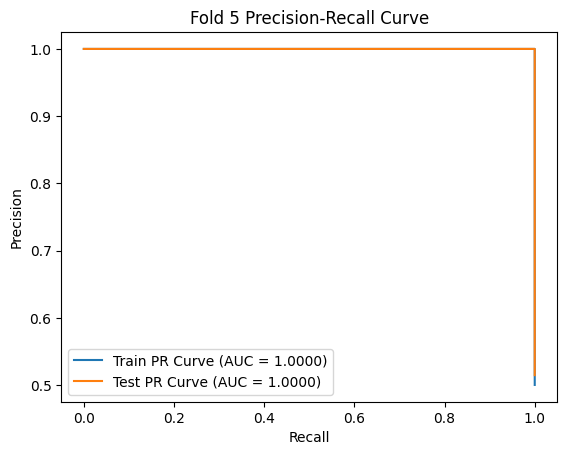

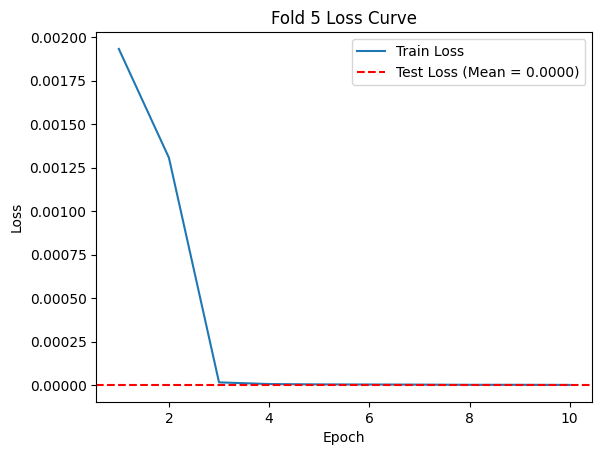

Fold 6 Train Confusion Matrix:
[[22201     0]
 [    0 22423]]
Fold 6 Test Confusion Matrix:
[[2497    0]
 [   0 2461]]
Fold 6 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22201
    Positive       1.00      1.00      1.00     22423

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 6 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2497
    Positive       1.00      1.00      1.00      2461

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



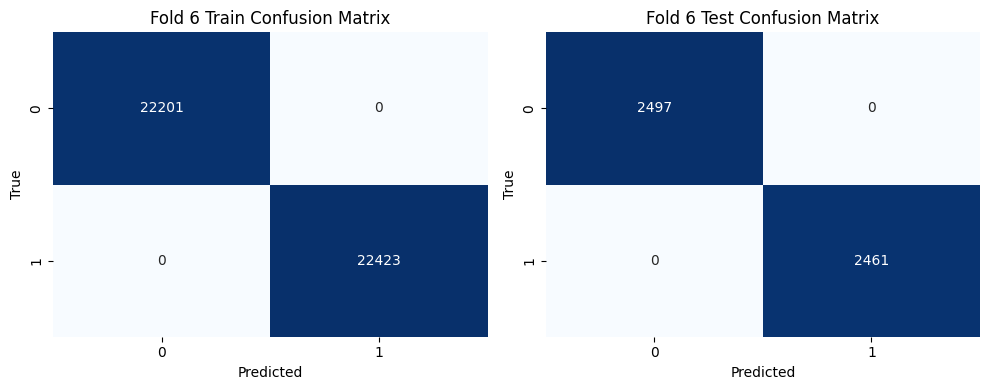

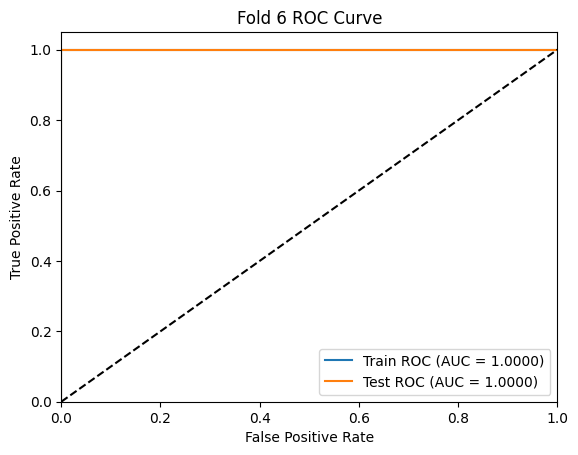

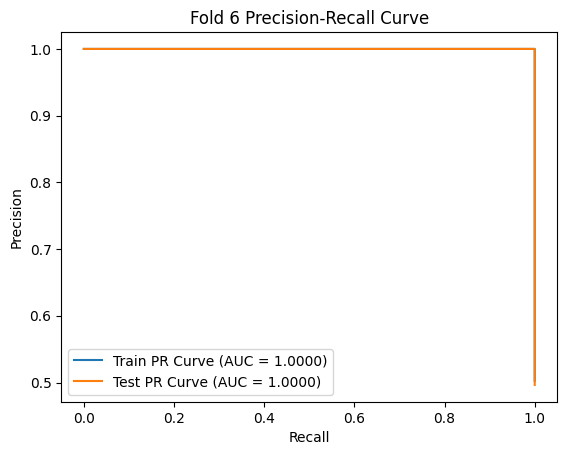

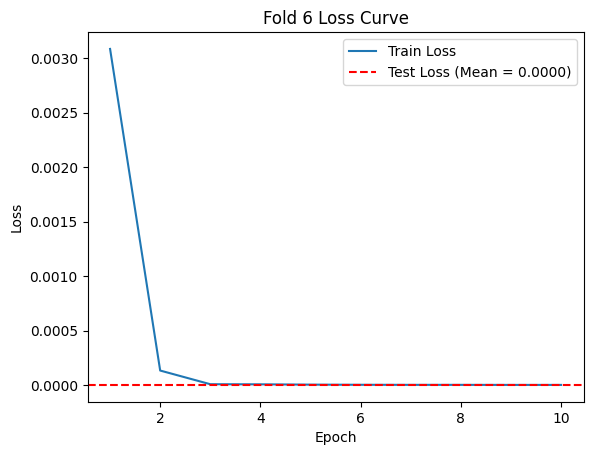

Fold 7 Train Confusion Matrix:
[[22227     0]
 [    0 22397]]
Fold 7 Test Confusion Matrix:
[[2471    0]
 [   0 2487]]
Fold 7 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22227
    Positive       1.00      1.00      1.00     22397

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 7 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2471
    Positive       1.00      1.00      1.00      2487

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



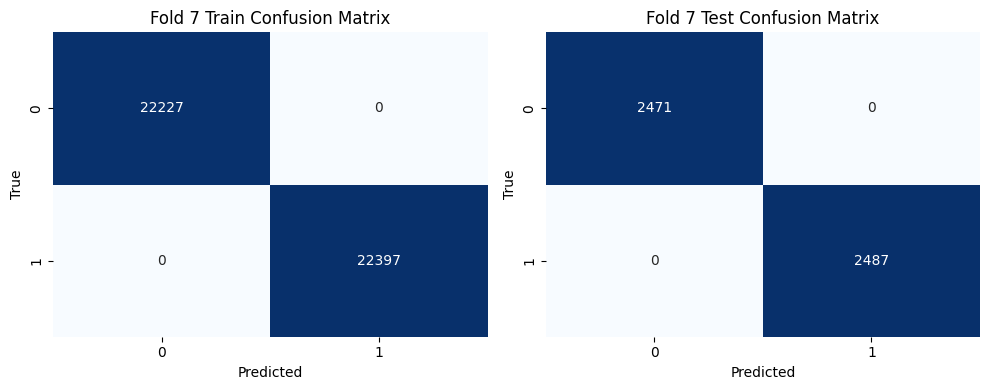

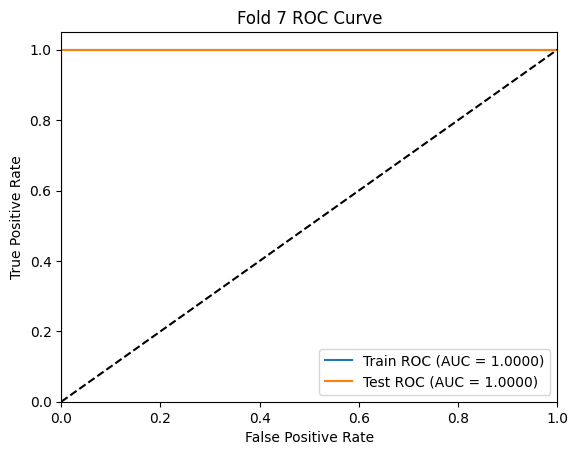

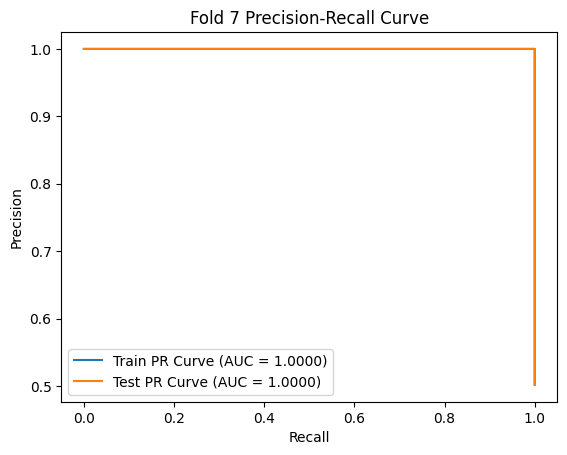

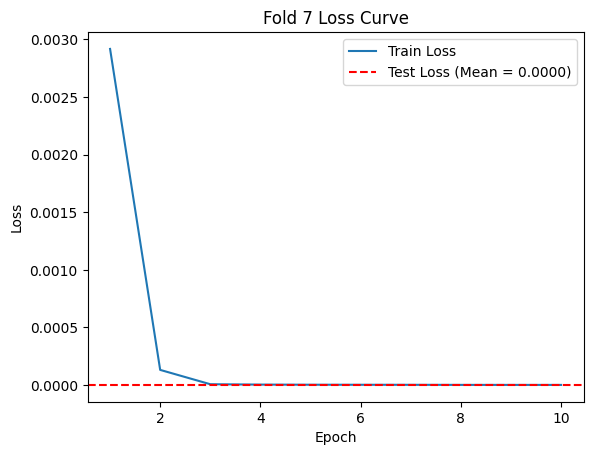

Fold 8 Train Confusion Matrix:
[[22225     0]
 [    0 22399]]
Fold 8 Test Confusion Matrix:
[[2473    0]
 [   0 2485]]
Fold 8 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22225
    Positive       1.00      1.00      1.00     22399

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 8 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2473
    Positive       1.00      1.00      1.00      2485

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



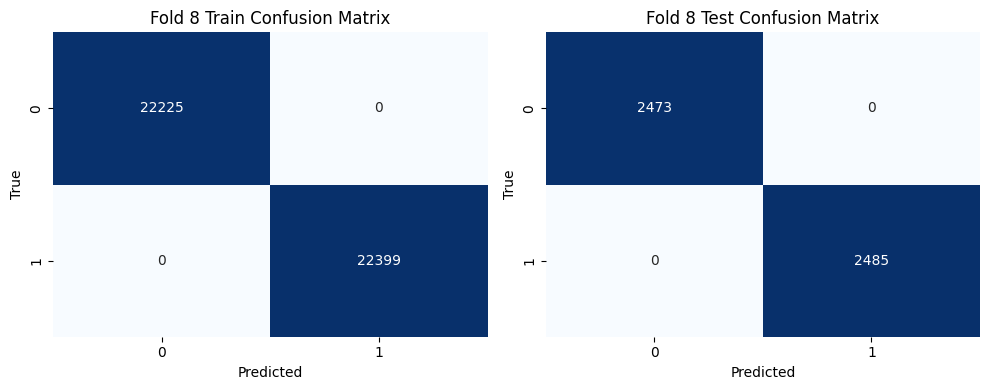

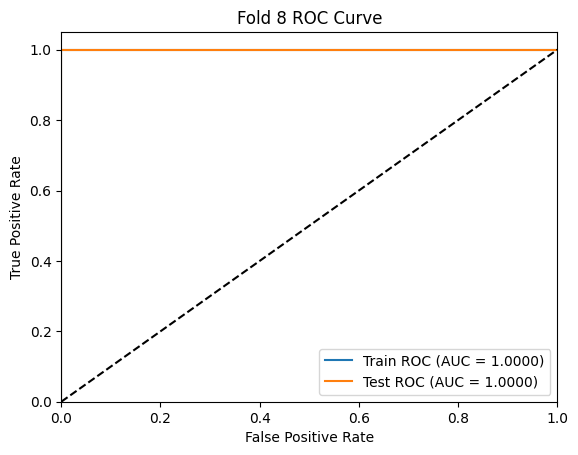

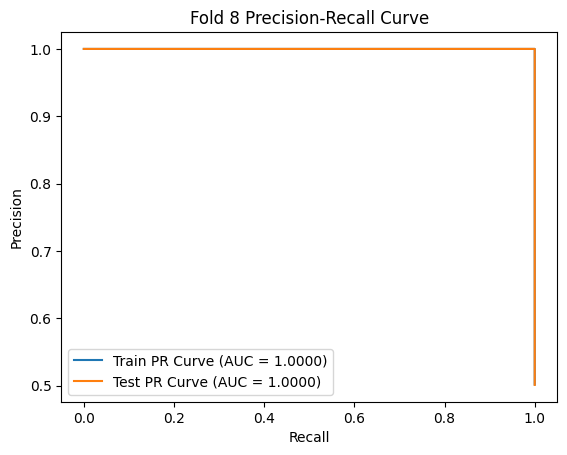

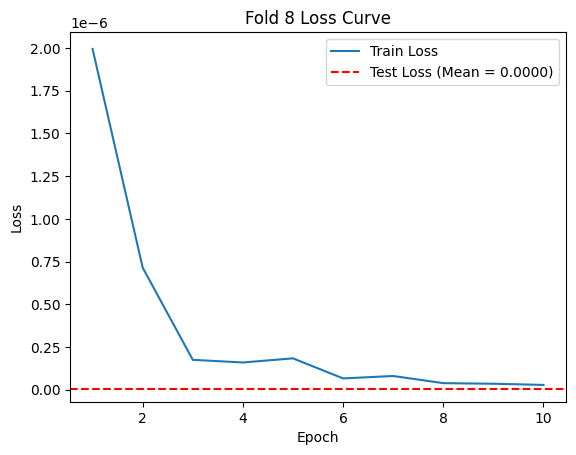

Fold 9 Train Confusion Matrix:
[[22259     0]
 [    0 22365]]
Fold 9 Test Confusion Matrix:
[[2439    0]
 [   0 2519]]
Fold 9 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22259
    Positive       1.00      1.00      1.00     22365

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 9 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2439
    Positive       1.00      1.00      1.00      2519

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



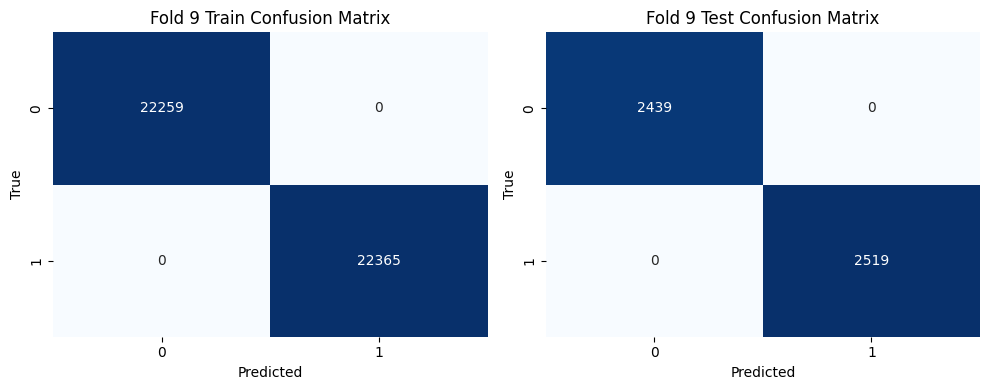

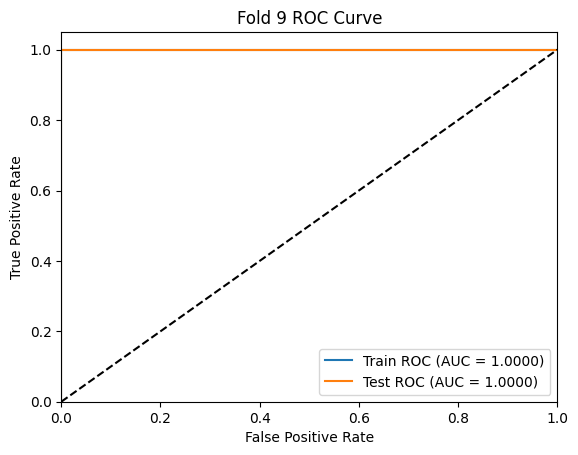

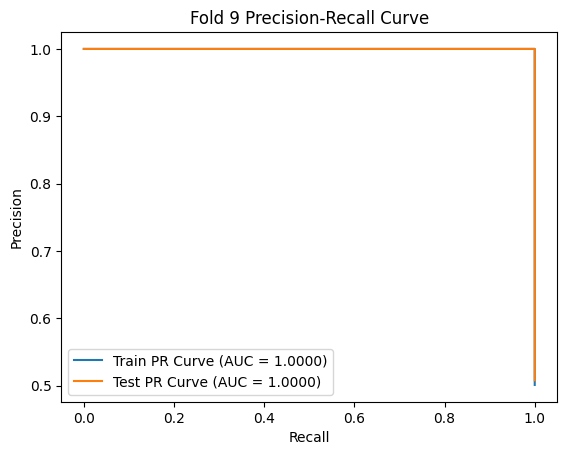

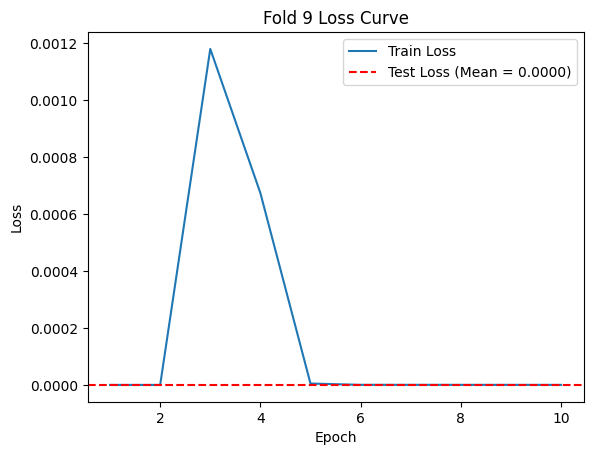

Fold 10 Train Confusion Matrix:
[[22196     0]
 [    0 22428]]
Fold 10 Test Confusion Matrix:
[[2502    0]
 [   0 2456]]
Fold 10 Train Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     22196
    Positive       1.00      1.00      1.00     22428

    accuracy                           1.00     44624
   macro avg       1.00      1.00      1.00     44624
weighted avg       1.00      1.00      1.00     44624

Fold 10 Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2502
    Positive       1.00      1.00      1.00      2456

    accuracy                           1.00      4958
   macro avg       1.00      1.00      1.00      4958
weighted avg       1.00      1.00      1.00      4958



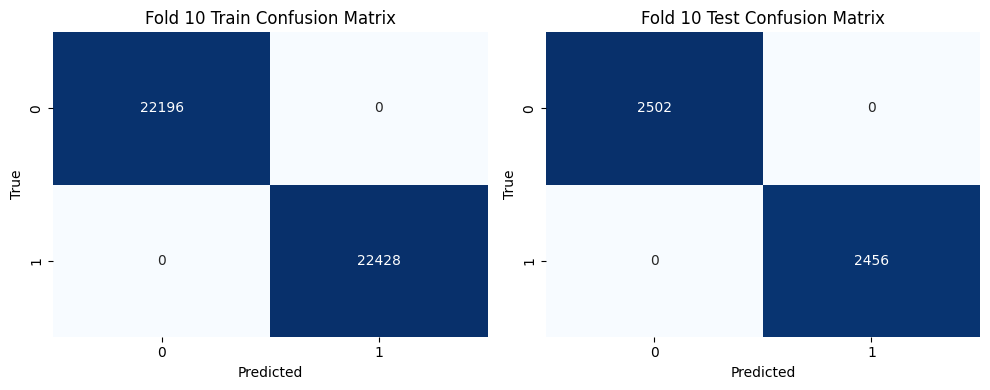

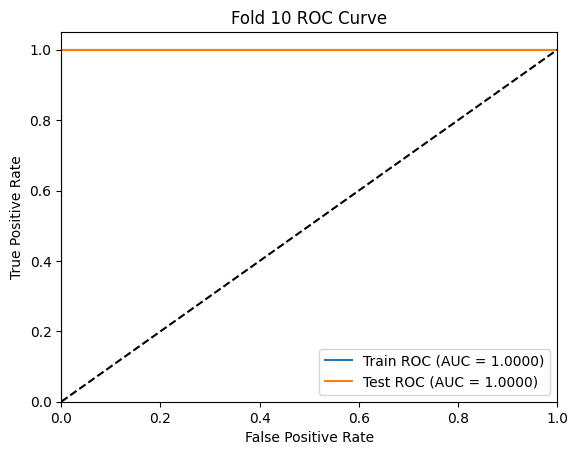

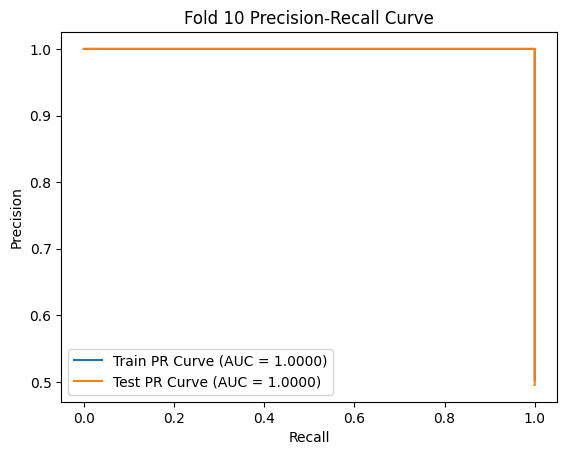

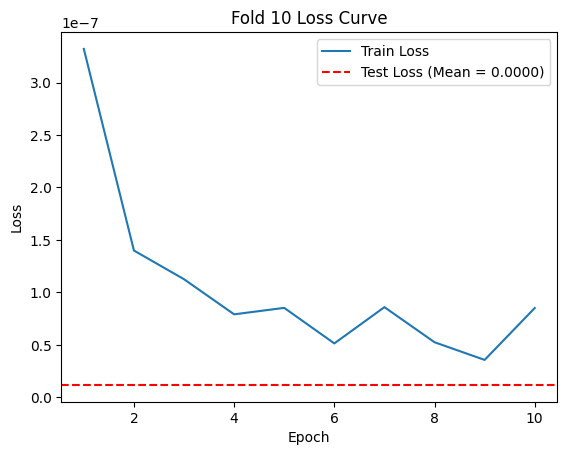

In [ ]:
all_fold_metrics = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    train_predictions = []
    train_true_labels = []
    train_probabilities = []
    train_losses = []
    test_predictions = []
    test_true_labels = []
    test_probabilities = []
    test_losses = []

    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            train_predictions.extend(preds)
            train_true_labels.extend(y_batch.cpu().numpy())
            train_probabilities.extend(probs)
            train_losses.append(loss.item())

        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            test_predictions.extend(preds)
            test_true_labels.extend(y_batch.cpu().numpy())
            test_probabilities.extend(probs)
            test_losses.append(loss.item())

    train_cm = confusion_matrix(train_true_labels, train_predictions)
    test_cm = confusion_matrix(test_true_labels, test_predictions)
    print(f"Fold {fold + 1} Train Confusion Matrix:")
    print(train_cm)
    print(f"Fold {fold + 1} Test Confusion Matrix:")
    print(test_cm)

    train_class_report = classification_report(train_true_labels, train_predictions, target_names=['Negative', 'Positive'])
    test_class_report = classification_report(test_true_labels, test_predictions, target_names=['Negative', 'Positive'])
    print(f"Fold {fold + 1} Train Classification Report:")
    print(train_class_report)
    print(f"Fold {fold + 1} Test Classification Report:")
    print(test_class_report)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Fold {fold + 1} Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Fold {fold + 1} Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    train_fpr, train_tpr, _ = roc_curve(train_true_labels, train_probabilities)
    train_roc_auc = auc(train_fpr, train_tpr)
    test_fpr, test_tpr, _ = roc_curve(test_true_labels, test_probabilities)
    test_roc_auc = auc(test_fpr, test_tpr)
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {train_roc_auc:.4f})')
    plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {test_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold + 1} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    train_precision, train_recall, _ = precision_recall_curve(train_true_labels, train_probabilities)
    train_pr_auc = auc(train_recall, train_precision)
    test_precision, test_recall, _ = precision_recall_curve(test_true_labels, test_probabilities)
    test_pr_auc = auc(test_recall, test_precision)
    plt.figure()
    plt.plot(train_recall, train_precision, label=f'Train PR Curve (AUC = {train_pr_auc:.4f})')
    plt.plot(test_recall, test_precision, label=f'Test PR Curve (AUC = {test_pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Fold {fold + 1} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    plt.figure()
    plt.plot(range(1, len(fold_losses[fold]) + 1), fold_losses[fold], label=f'Train Loss')
    plt.axhline(y=np.mean(test_losses), color='r', linestyle='--', label=f'Test Loss (Mean = {np.mean(test_losses):.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} Loss Curve')
    plt.legend()
    plt.show()

    all_fold_metrics.append({
        'fold': fold + 1,
        'train_accuracy': accuracy_score(train_true_labels, train_predictions),
        'train_precision': precision_score(train_true_labels, train_predictions, average='binary'),
        'train_recall': recall_score(train_true_labels, train_predictions, average='binary'),
        'train_f1': f1_score(train_true_labels, train_predictions, average='binary'),
        'train_roc_auc': roc_auc_score(train_true_labels, train_predictions),
        'train_pr_auc': train_pr_auc,
        'train_cm': train_cm,
        'train_class_report': train_class_report,
        'test_accuracy': accuracy_score(test_true_labels, test_predictions),
        'test_precision': precision_score(test_true_labels, test_predictions, average='binary'),
        'test_recall': recall_score(test_true_labels, test_predictions, average='binary'),
        'test_f1': f1_score(test_true_labels, test_predictions, average='binary'),
        'test_roc_auc': roc_auc_score(test_true_labels, test_predictions),
        'test_pr_auc': test_pr_auc,
        'test_cm': test_cm,
        'test_class_report': test_class_report
    })

## Summary

In [51]:
avg_metrics = {
    'train_accuracy': np.mean([m['train_accuracy'] for m in all_fold_metrics]),
    'train_precision': np.mean([m['train_precision'] for m in all_fold_metrics]),
    'train_recall': np.mean([m['train_recall'] for m in all_fold_metrics]),
    'train_f1': np.mean([m['train_f1'] for m in all_fold_metrics]),
    'train_roc_auc': np.mean([m['train_roc_auc'] for m in all_fold_metrics]),
    'train_pr_auc': np.mean([m['train_pr_auc'] for m in all_fold_metrics]),
    'test_accuracy': np.mean([m['test_accuracy'] for m in all_fold_metrics]),
    'test_precision': np.mean([m['test_precision'] for m in all_fold_metrics]),
    'test_recall': np.mean([m['test_recall'] for m in all_fold_metrics]),
    'test_f1': np.mean([m['test_f1'] for m in all_fold_metrics]),
    'test_roc_auc': np.mean([m['test_roc_auc'] for m in all_fold_metrics]),
    'test_pr_auc': np.mean([m['test_pr_auc'] for m in all_fold_metrics])
}

std_metrics = {
    'train_accuracy': np.std([m['train_accuracy'] for m in all_fold_metrics]),
    'train_precision': np.std([m['train_precision'] for m in all_fold_metrics]),
    'train_recall': np.std([m['train_recall'] for m in all_fold_metrics]),
    'train_f1': np.std([m['train_f1'] for m in all_fold_metrics]),
    'train_roc_auc': np.std([m['train_roc_auc'] for m in all_fold_metrics]),
    'train_pr_auc': np.std([m['train_pr_auc'] for m in all_fold_metrics]),
    'test_accuracy': np.std([m['test_accuracy'] for m in all_fold_metrics]),
    'test_precision': np.std([m['test_precision'] for m in all_fold_metrics]),
    'test_recall': np.std([m['test_recall'] for m in all_fold_metrics]),
    'test_f1': np.std([m['test_f1'] for m in all_fold_metrics]),
    'test_roc_auc': np.std([m['test_roc_auc'] for m in all_fold_metrics]),
    'test_pr_auc': np.std([m['test_pr_auc'] for m in all_fold_metrics])
}

print("Average Metrics Across All Folds (Train):")
print(f"Accuracy: {avg_metrics['train_accuracy']:.4f} ± {std_metrics['train_accuracy']:.4f}")
print(f"Precision: {avg_metrics['train_precision']:.4f} ± {std_metrics['train_precision']:.4f}")
print(f"Recall: {avg_metrics['train_recall']:.4f} ± {std_metrics['train_recall']:.4f}")
print(f"F1: {avg_metrics['train_f1']:.4f} ± {std_metrics['train_f1']:.4f}")
print(f"ROC-AUC: {avg_metrics['train_roc_auc']:.4f} ± {std_metrics['train_roc_auc']:.4f}")
print(f"PR-AUC: {avg_metrics['train_pr_auc']:.4f} ± {std_metrics['train_pr_auc']:.4f}")

print("Average Metrics Across All Folds (Test):")
print(f"Accuracy: {avg_metrics['test_accuracy']:.4f} ± {std_metrics['test_accuracy']:.4f}")
print(f"Precision: {avg_metrics['test_precision']:.4f} ± {std_metrics['test_precision']:.4f}")
print(f"Recall: {avg_metrics['test_recall']:.4f} ± {std_metrics['test_recall']:.4f}")
print(f"F1: {avg_metrics['test_f1']:.4f} ± {std_metrics['test_f1']:.4f}")
print(f"ROC-AUC: {avg_metrics['test_roc_auc']:.4f} ± {std_metrics['test_roc_auc']:.4f}")
print(f"PR-AUC: {avg_metrics['test_pr_auc']:.4f} ± {std_metrics['test_pr_auc']:.4f}")

Average Metrics Across All Folds (Train):
Accuracy: 1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall: 1.0000 ± 0.0000
F1: 1.0000 ± 0.0000
ROC-AUC: 1.0000 ± 0.0000
PR-AUC: 1.0000 ± 0.0000
Average Metrics Across All Folds (Test):
Accuracy: 1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall: 1.0000 ± 0.0000
F1: 1.0000 ± 0.0000
ROC-AUC: 1.0000 ± 0.0000
PR-AUC: 1.0000 ± 0.0000


# Interpretasi Bisnis

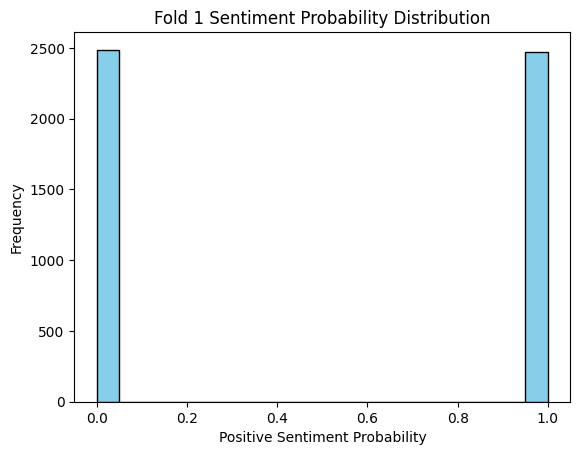

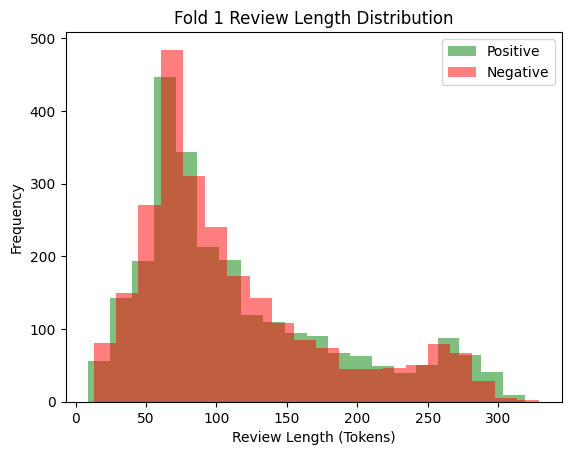

Fold 1 Business Insights:
Percentage of Positive Reviews: 49.85%
Percentage of Negative Reviews: 50.15%
Top 10 Positive Words: [('film', 3677), ('movie', 3501), ('one', 2470), ('like', 1651), ('good', 1380), ('story', 1234), ('time', 1192), ('great', 1179), ('see', 1168), ('well', 1074)]
Top 10 Negative Words: [('movie', 4352), ('film', 3234), ('one', 2302), ('like', 2064), ('good', 1344), ('even', 1341), ('bad', 1293), ('would', 1276), ('really', 1172), ('time', 1082)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'story': np.float32(0.5377512), 'time': np.float32(0.8133447), 'great': np.float32(1.0708649), 'see': np.float32(0.93579423), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float3

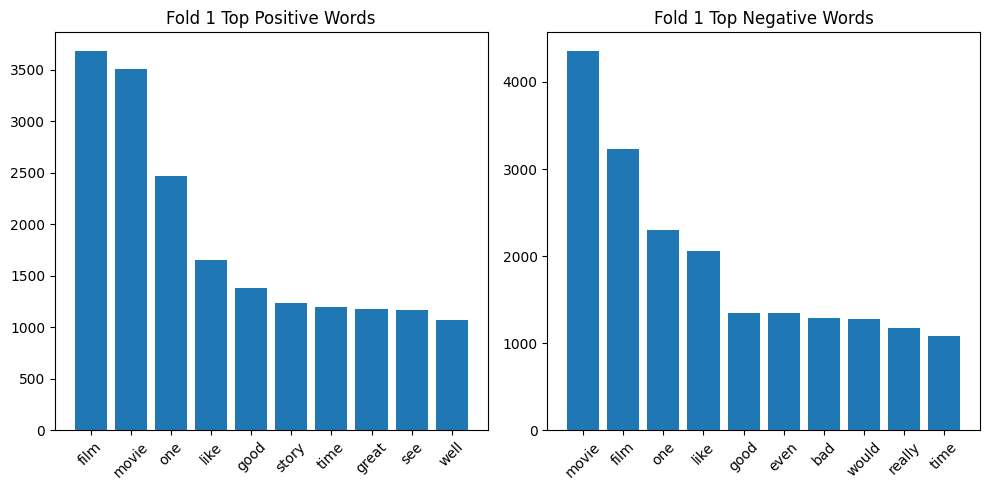

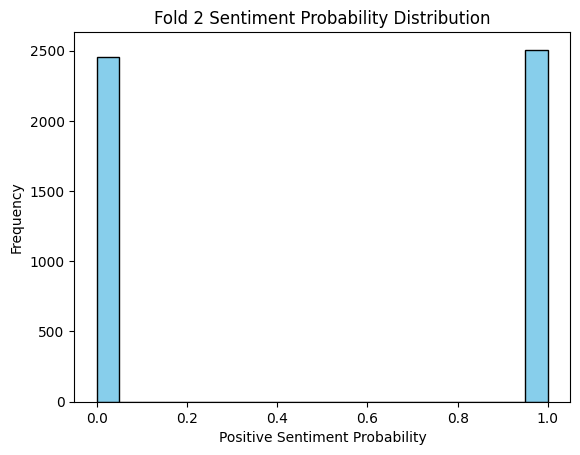

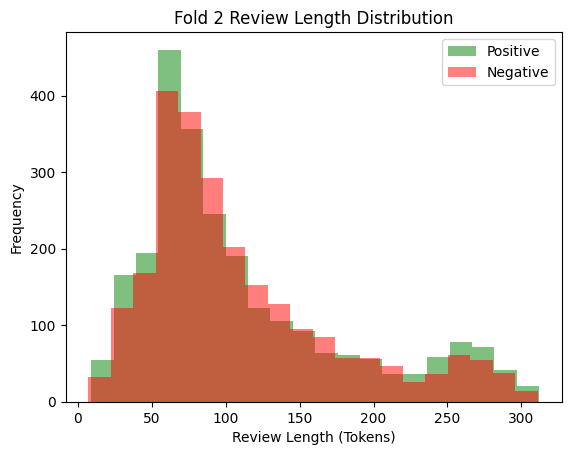

Fold 2 Business Insights:
Percentage of Positive Reviews: 50.53%
Percentage of Negative Reviews: 49.47%
Top 10 Positive Words: [('film', 3780), ('movie', 3476), ('one', 2457), ('like', 1601), ('good', 1347), ('story', 1262), ('great', 1204), ('see', 1145), ('time', 1130), ('really', 1074)]
Top 10 Negative Words: [('movie', 4422), ('film', 3273), ('one', 2200), ('like', 2083), ('even', 1351), ('bad', 1303), ('good', 1271), ('would', 1250), ('really', 1203), ('time', 1112)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'story': np.float32(0.5377512), 'great': np.float32(1.0708649), 'see': np.float32(0.93579423), 'time': np.float32(0.8133447), 'really': np.float32(0.41099533)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.fl

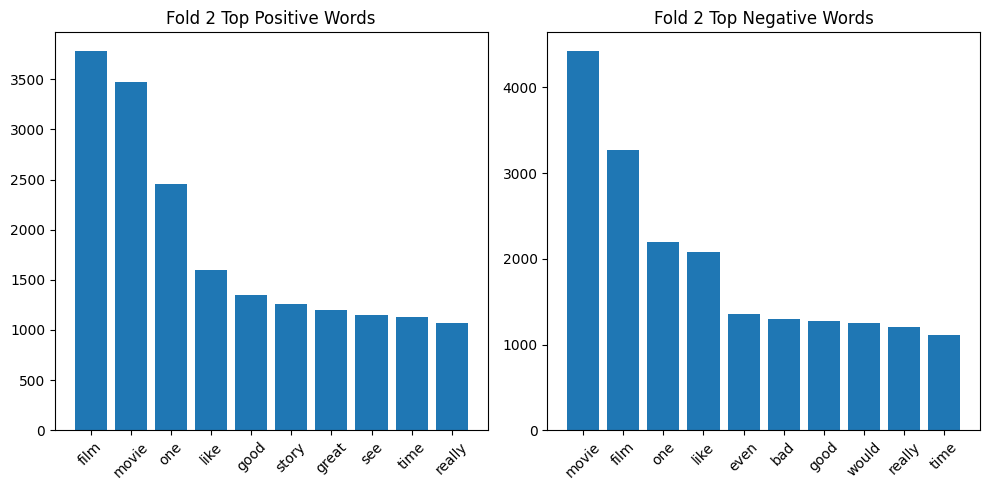

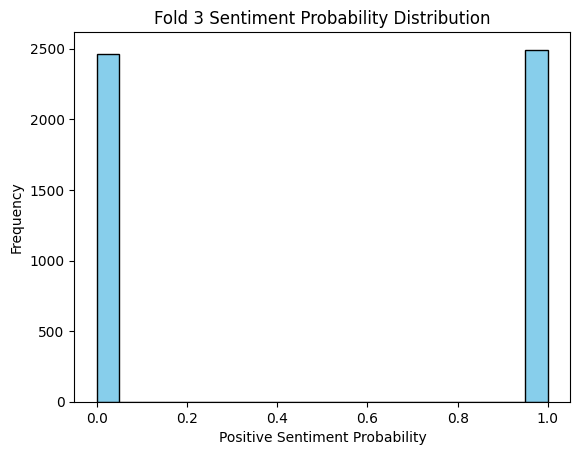

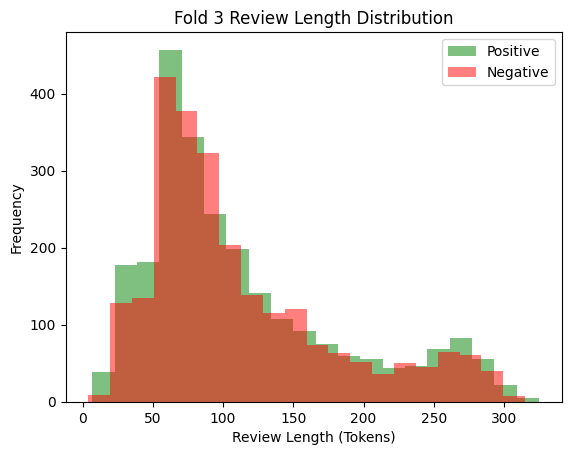

Fold 3 Business Insights:
Percentage of Positive Reviews: 50.28%
Percentage of Negative Reviews: 49.72%
Top 10 Positive Words: [('film', 3781), ('movie', 3456), ('one', 2308), ('like', 1615), ('good', 1432), ('great', 1241), ('story', 1185), ('see', 1162), ('time', 1129), ('well', 1070)]
Top 10 Negative Words: [('movie', 4730), ('film', 3281), ('one', 2300), ('like', 2087), ('even', 1417), ('good', 1351), ('bad', 1343), ('would', 1294), ('really', 1170), ('time', 1063)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'see': np.float32(0.93579423), 'time': np.float32(0.8133447), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

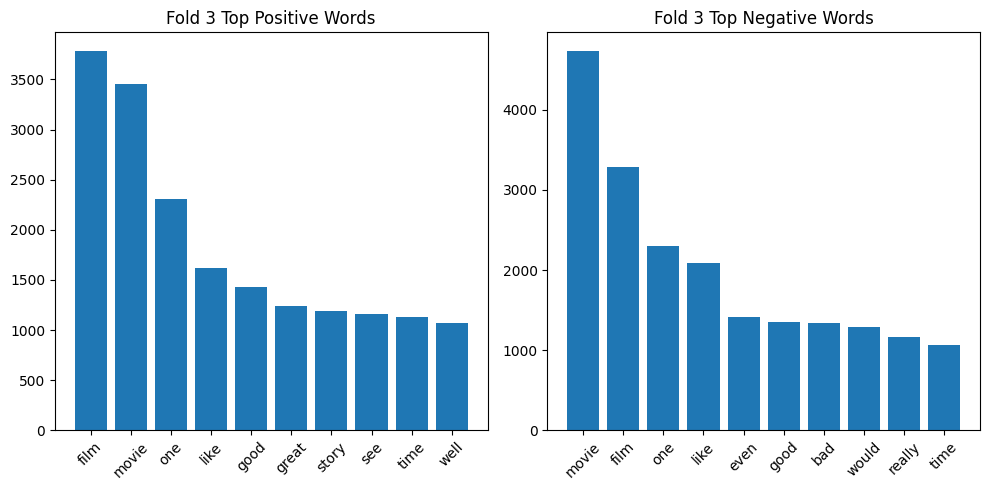

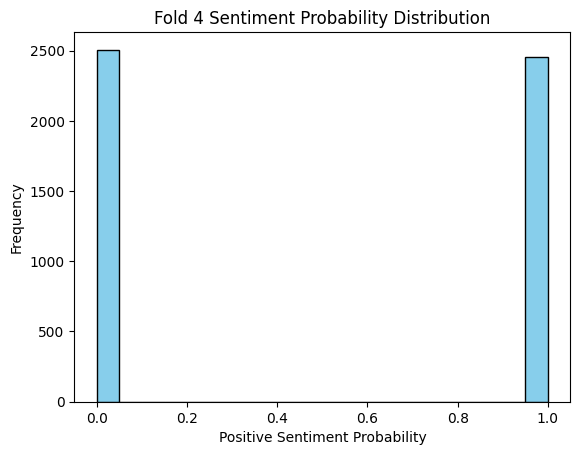

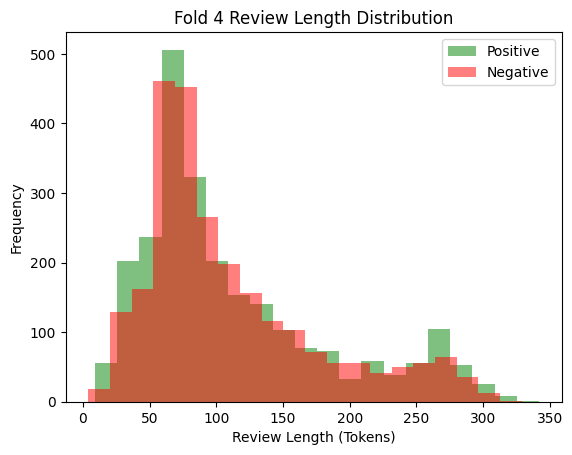

Fold 4 Business Insights:
Percentage of Positive Reviews: 49.46%
Percentage of Negative Reviews: 50.54%
Top 10 Positive Words: [('film', 3641), ('movie', 3410), ('one', 2359), ('like', 1598), ('good', 1227), ('great', 1139), ('story', 1121), ('really', 1061), ('see', 1060), ('time', 1051)]
Top 10 Negative Words: [('movie', 4799), ('film', 3202), ('one', 2334), ('like', 2063), ('even', 1414), ('bad', 1408), ('good', 1331), ('would', 1279), ('really', 1147), ('time', 1082)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'really': np.float32(0.41099533), 'see': np.float32(0.93579423), 'time': np.float32(0.8133447)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.fl

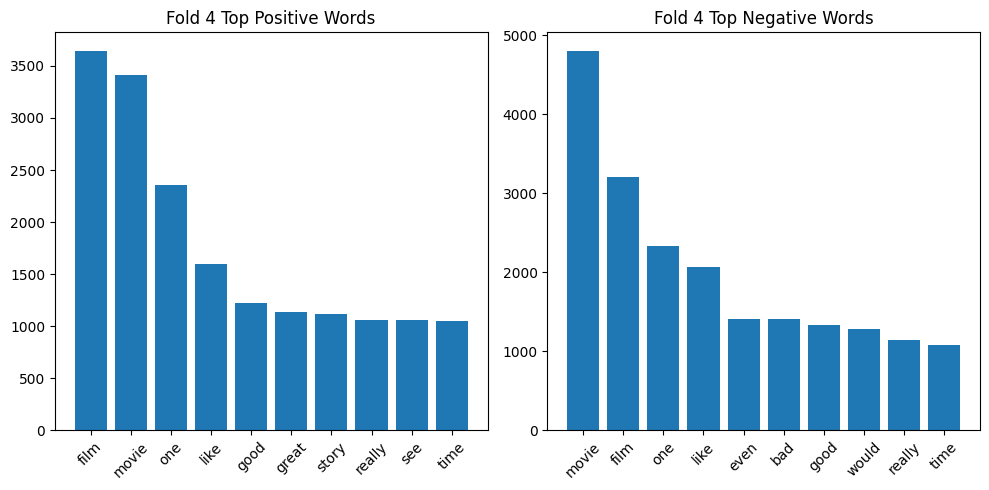

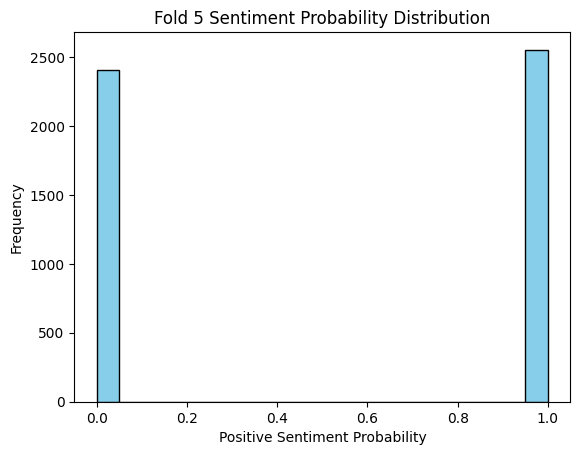

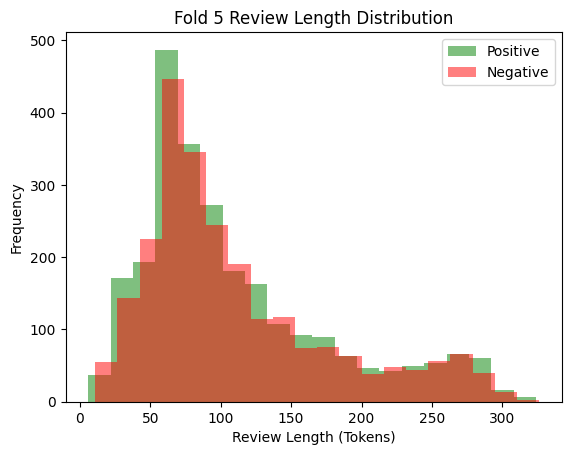

Fold 5 Business Insights:
Percentage of Positive Reviews: 51.49%
Percentage of Negative Reviews: 48.51%
Top 10 Positive Words: [('film', 3558), ('movie', 3555), ('one', 2452), ('like', 1532), ('good', 1385), ('great', 1226), ('time', 1197), ('story', 1182), ('see', 1116), ('well', 1019)]
Top 10 Negative Words: [('movie', 4408), ('film', 3138), ('one', 2303), ('like', 1940), ('even', 1410), ('bad', 1346), ('good', 1323), ('would', 1209), ('really', 1167), ('time', 1072)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'time': np.float32(0.8133447), 'story': np.float32(0.5377512), 'see': np.float32(0.93579423), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

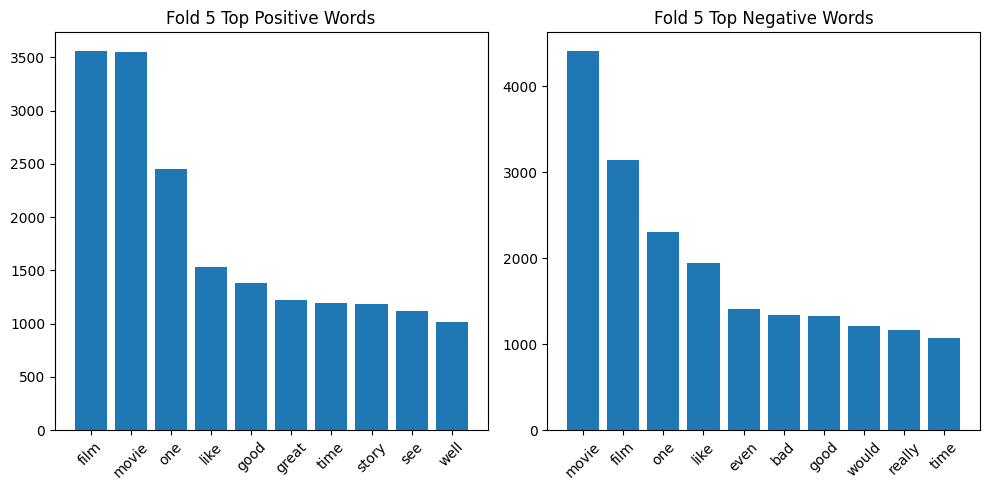

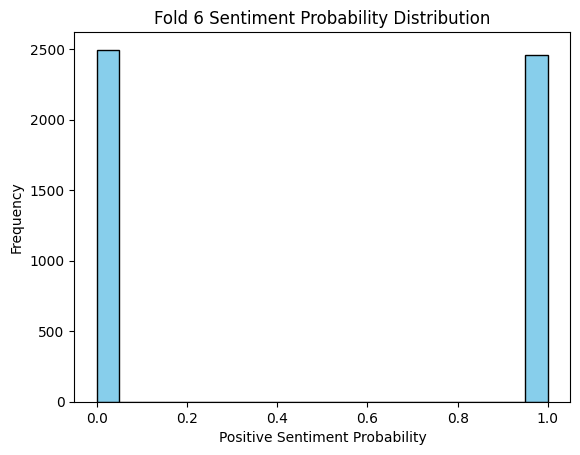

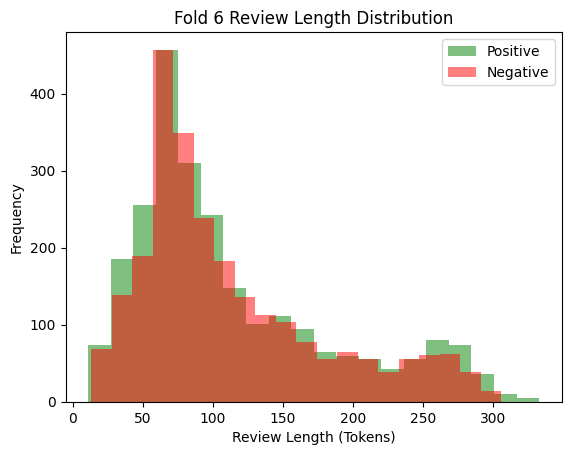

Fold 6 Business Insights:
Percentage of Positive Reviews: 49.64%
Percentage of Negative Reviews: 50.36%
Top 10 Positive Words: [('film', 3662), ('movie', 3533), ('one', 2377), ('like', 1593), ('good', 1389), ('great', 1183), ('story', 1138), ('time', 1128), ('see', 1096), ('well', 1027)]
Top 10 Negative Words: [('movie', 4703), ('film', 3245), ('one', 2408), ('like', 2014), ('good', 1390), ('even', 1376), ('would', 1321), ('bad', 1311), ('really', 1101), ('time', 1037)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'time': np.float32(0.8133447), 'see': np.float32(0.93579423), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float3

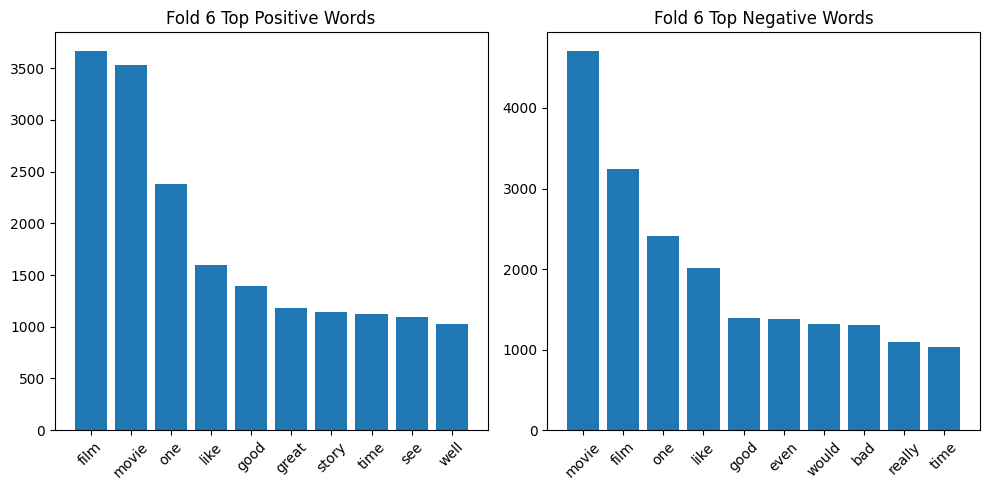

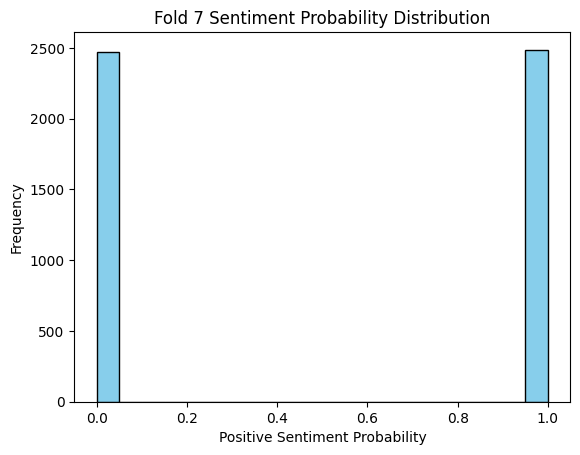

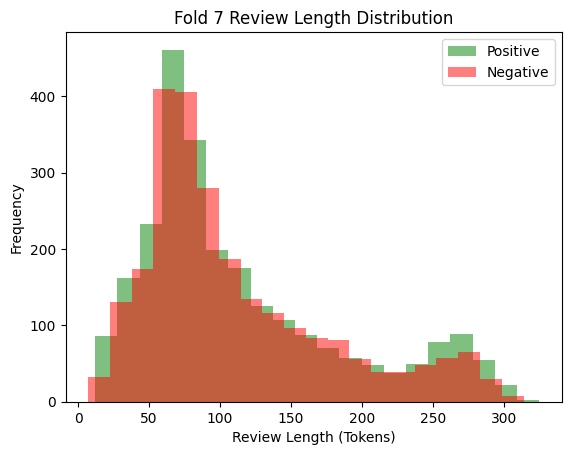

Fold 7 Business Insights:
Percentage of Positive Reviews: 50.16%
Percentage of Negative Reviews: 49.84%
Top 10 Positive Words: [('film', 3855), ('movie', 3489), ('one', 2406), ('like', 1644), ('good', 1302), ('great', 1228), ('story', 1139), ('time', 1120), ('see', 1096), ('also', 1016)]
Top 10 Negative Words: [('movie', 4547), ('film', 3317), ('one', 2302), ('like', 2020), ('even', 1383), ('would', 1330), ('bad', 1295), ('good', 1275), ('really', 1165), ('time', 1078)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'time': np.float32(0.8133447), 'see': np.float32(0.93579423), 'also': np.float32(0.63406503)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

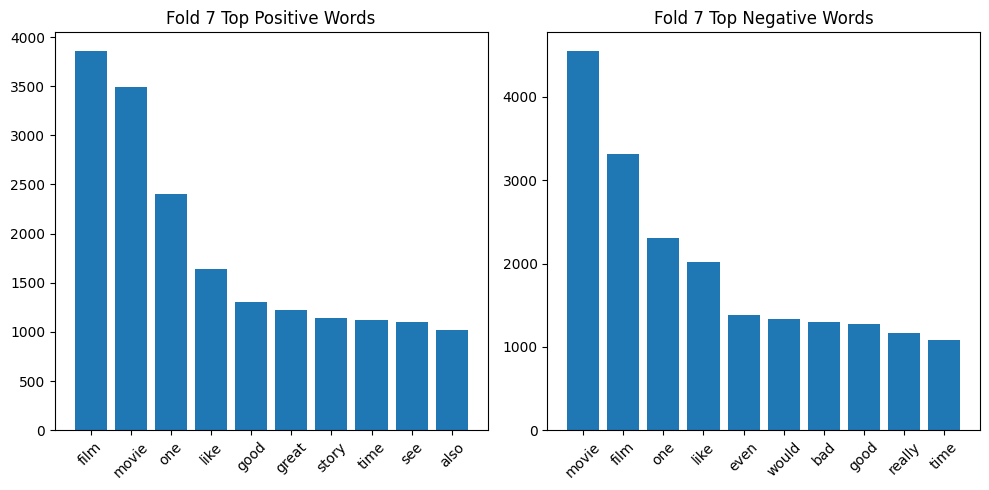

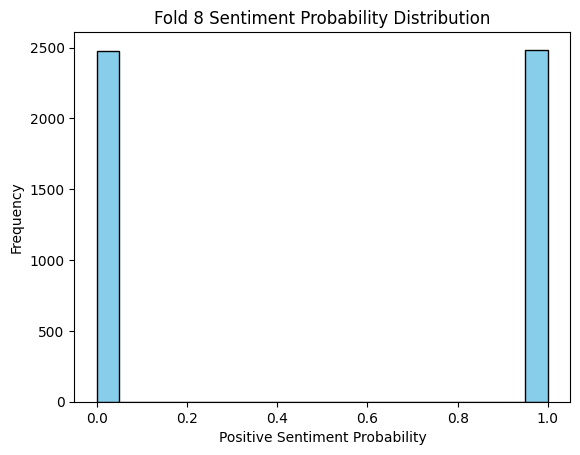

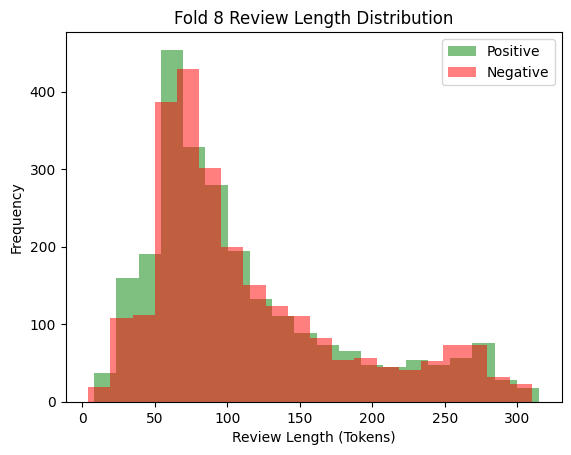

Fold 8 Business Insights:
Percentage of Positive Reviews: 50.12%
Percentage of Negative Reviews: 49.88%
Top 10 Positive Words: [('film', 3661), ('movie', 3375), ('one', 2401), ('like', 1573), ('good', 1370), ('story', 1232), ('great', 1165), ('see', 1096), ('time', 1024), ('well', 1009)]
Top 10 Negative Words: [('movie', 4577), ('film', 3238), ('one', 2479), ('like', 2111), ('even', 1441), ('good', 1333), ('bad', 1314), ('would', 1272), ('time', 1102), ('really', 1090)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'story': np.float32(0.5377512), 'great': np.float32(1.0708649), 'see': np.float32(0.93579423), 'time': np.float32(0.8133447), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

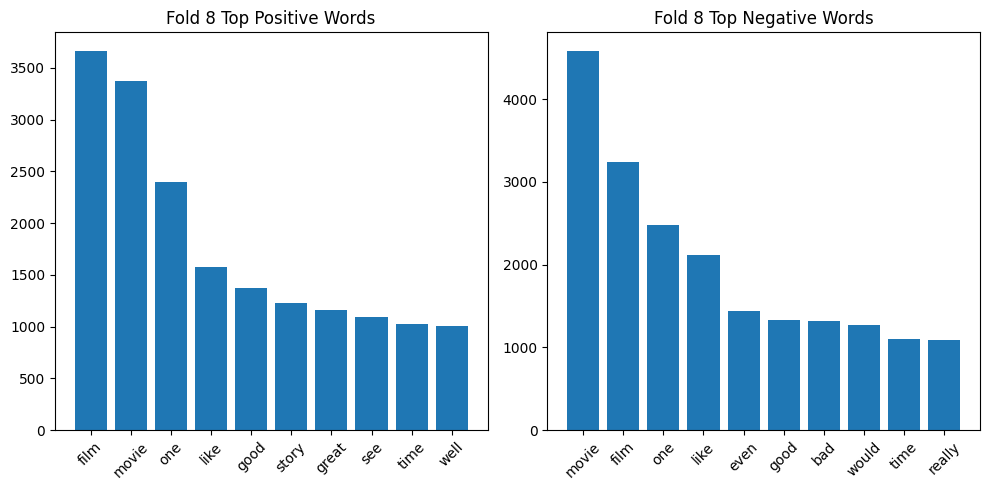

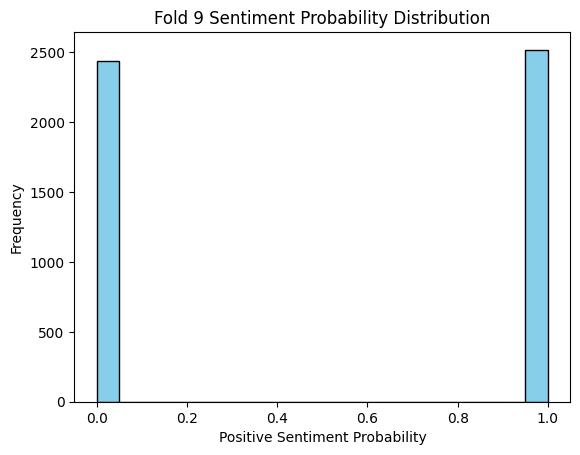

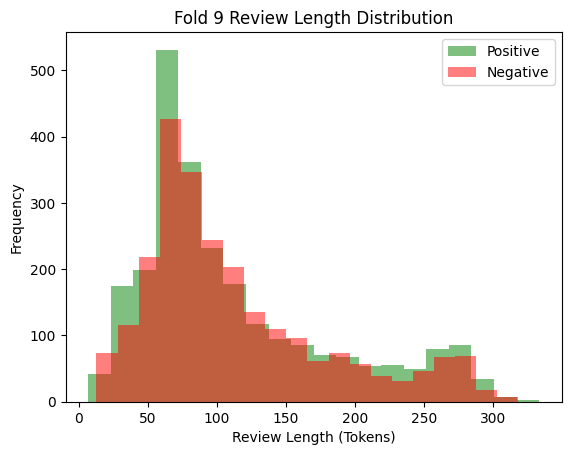

Fold 9 Business Insights:
Percentage of Positive Reviews: 50.81%
Percentage of Negative Reviews: 49.19%
Top 10 Positive Words: [('film', 3658), ('movie', 3588), ('one', 2377), ('like', 1693), ('good', 1390), ('great', 1278), ('story', 1190), ('see', 1170), ('well', 1011), ('time', 1008)]
Top 10 Negative Words: [('movie', 4433), ('film', 3554), ('one', 2297), ('like', 1985), ('even', 1406), ('good', 1377), ('bad', 1352), ('would', 1247), ('really', 1190), ('time', 1125)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'see': np.float32(0.93579423), 'well': np.float32(0.86084914), 'time': np.float32(0.8133447)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

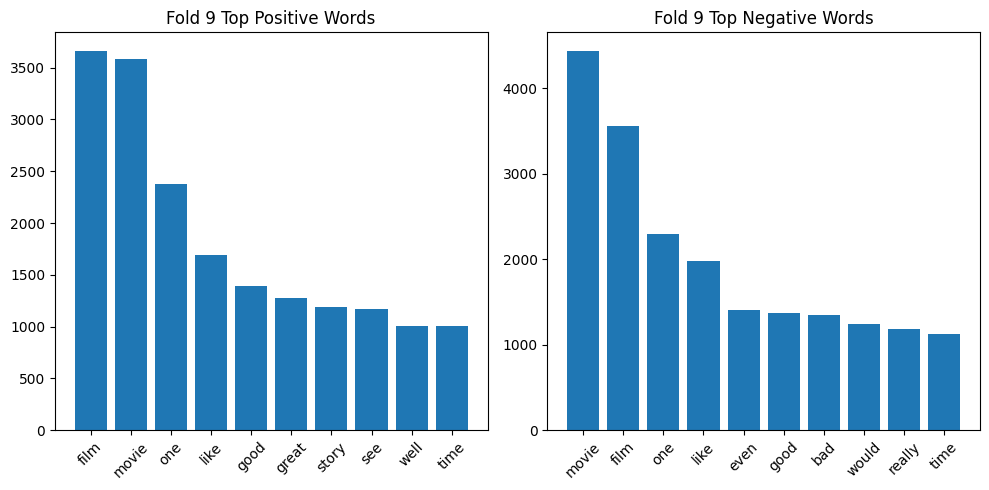

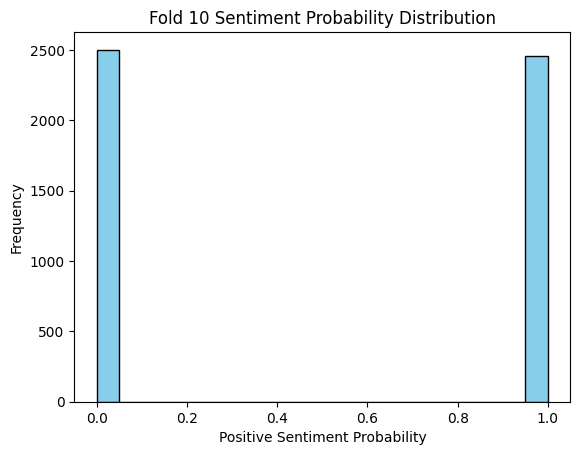

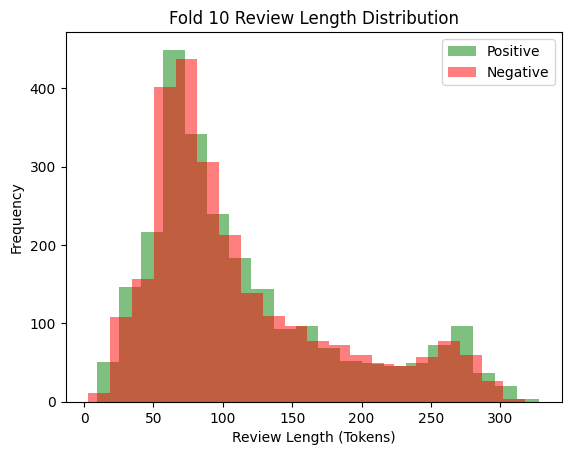

Fold 10 Business Insights:
Percentage of Positive Reviews: 49.54%
Percentage of Negative Reviews: 50.46%
Top 10 Positive Words: [('film', 3679), ('movie', 3388), ('one', 2437), ('like', 1536), ('good', 1387), ('great', 1241), ('story', 1189), ('time', 1105), ('see', 1090), ('well', 1027)]
Top 10 Negative Words: [('movie', 4606), ('film', 3392), ('one', 2275), ('like', 2108), ('even', 1495), ('bad', 1426), ('good', 1391), ('would', 1296), ('really', 1135), ('see', 1064)]
Positive Word Importance Scores: {'film': np.float32(0.48934105), 'movie': np.float32(0.7539092), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'good': np.float32(0.66930974), 'great': np.float32(1.0708649), 'story': np.float32(0.5377512), 'time': np.float32(0.8133447), 'see': np.float32(0.93579423), 'well': np.float32(0.86084914)}
Negative Word Importance Scores: {'movie': np.float32(0.7539092), 'film': np.float32(0.48934105), 'one': np.float32(0.577792), 'like': np.float32(0.63720846), 'even': np.float3

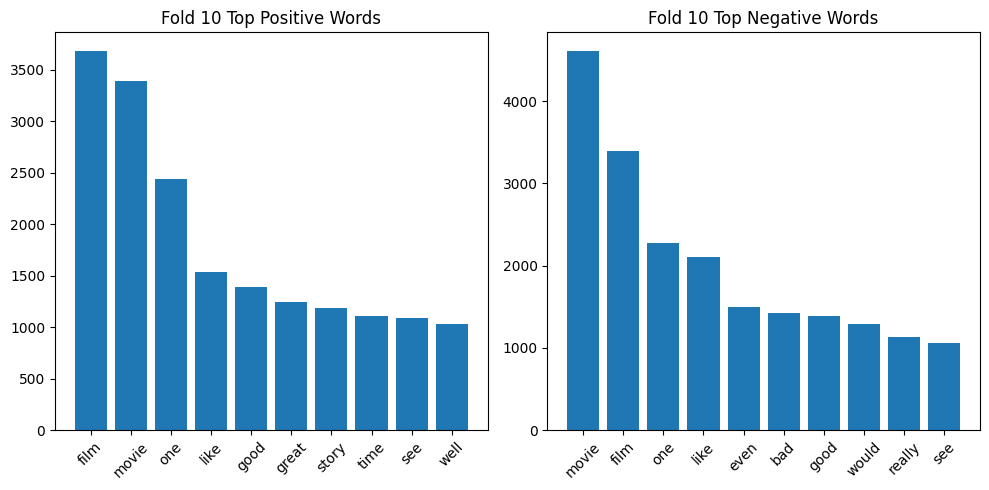

In [ ]:
inverse_vocab = {idx: word for word, idx in vocab.items()}
business_insights = []
splits = list(kf.split(X))

for fold, (_, test_idx) in enumerate(splits):
    test_predictions = []
    test_true_labels = []
    test_probabilities = []
    test_texts = df['tokens_no_stopwords'].iloc[test_idx].tolist()

    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X[test_idx], dtype=torch.long), 
        torch.tensor(y[test_idx], dtype=torch.long)
    )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            test_predictions.extend(preds)
            test_true_labels.extend(y_batch.cpu().numpy())
            test_probabilities.extend(probs)

    positive_reviews = [test_texts[i] for i, pred in enumerate(test_predictions) if pred == 1]
    negative_reviews = [test_texts[i] for i, pred in enumerate(test_predictions) if pred == 0]
    positive_words = Counter([word for review in positive_reviews for word in review])
    negative_words = Counter([word for review in negative_reviews for word in review])
    top_positive_words = positive_words.most_common(10)
    top_negative_words = negative_words.most_common(10)

    positive_percentage = sum(test_predictions) / len(test_predictions) * 100
    negative_percentage = 100 - positive_percentage

    embedding_weights = model.embedding.weight.detach().cpu().numpy()
    word_importance = np.mean(np.abs(embedding_weights), axis=1)
    top_positive_word_indices = [vocab[word] for word, _ in top_positive_words if word in vocab]
    top_negative_word_indices = [vocab[word] for word, _ in top_negative_words if word in vocab]
    positive_word_scores = {inverse_vocab[idx]: word_importance[idx] for idx in top_positive_word_indices}
    negative_word_scores = {inverse_vocab[idx]: word_importance[idx] for idx in top_negative_word_indices}

    positive_review_lengths = [len(review) for review in positive_reviews]
    negative_review_lengths = [len(review) for review in negative_reviews]
    avg_positive_length = np.mean(positive_review_lengths) if positive_review_lengths else 0
    avg_negative_length = np.mean(negative_review_lengths) if negative_review_lengths else 0

    plt.figure()
    plt.hist(test_probabilities, bins=20, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title(f'Fold {fold + 1} Sentiment Probability Distribution')
    plt.xlabel('Positive Sentiment Probability')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    plt.hist(positive_review_lengths, bins=20, alpha=0.5, label='Positive', color='green')
    plt.hist(negative_review_lengths, bins=20, alpha=0.5, label='Negative', color='red')
    plt.title(f'Fold {fold + 1} Review Length Distribution')
    plt.xlabel('Review Length (Tokens)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    business_insights.append({
        'fold': fold + 1,
        'positive_percentage': positive_percentage,
        'negative_percentage': negative_percentage,
        'top_positive_words': top_positive_words,
        'top_negative_words': top_negative_words,
        'positive_word_scores': positive_word_scores,
        'negative_word_scores': negative_word_scores,
        'test_accuracy': all_fold_metrics[fold]['test_accuracy'],
        'test_f1': all_fold_metrics[fold]['test_f1'],
        'test_roc_auc': all_fold_metrics[fold]['test_roc_auc'],
        'avg_positive_review_length': avg_positive_length,
        'avg_negative_review_length': avg_negative_length
    })

    print(f"Fold {fold + 1} Business Insights:")
    print(f"Percentage of Positive Reviews: {positive_percentage:.2f}%")
    print(f"Percentage of Negative Reviews: {negative_percentage:.2f}%")
    print(f"Top 10 Positive Words: {top_positive_words}")
    print(f"Top 10 Negative Words: {top_negative_words}")
    print(f"Positive Word Importance Scores: {positive_word_scores}")
    print(f"Negative Word Importance Scores: {negative_word_scores}")
    print(f"Average Positive Review Length: {avg_positive_length:.2f} tokens")
    print(f"Average Negative Review Length: {avg_negative_length:.2f} tokens")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    words, counts = zip(*top_positive_words)
    plt.bar(words, counts)
    plt.title(f'Fold {fold + 1} Top Positive Words')
    plt.xticks(rotation=45)
    plt.subplot(1, 2, 2)
    words, counts = zip(*top_negative_words)
    plt.bar(words, counts)
    plt.title(f'Fold {fold + 1} Top Negative Words')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [55]:
avg_positive_percentage = np.mean([insight['positive_percentage'] for insight in business_insights])
avg_negative_percentage = np.mean([insight['negative_percentage'] for insight in business_insights])
avg_test_accuracy = np.mean([insight['test_accuracy'] for insight in business_insights])
avg_test_f1 = np.mean([insight['test_f1'] for insight in business_insights])
avg_test_roc_auc = np.mean([insight['test_roc_auc'] for insight in business_insights])
avg_positive_length = np.mean([insight['avg_positive_review_length'] for insight in business_insights])
avg_negative_length = np.mean([insight['avg_negative_review_length'] for insight in business_insights])

print("Average Business Insights Across All Folds:")
print(f"Average Positive Reviews: {avg_positive_percentage:.2f}%")
print(f"Average Negative Reviews: {avg_negative_percentage:.2f}%")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")
print(f"Average Test F1-Score: {avg_test_f1:.4f}")
print(f"Average Test ROC-AUC: {avg_test_roc_auc:.4f}")
print(f"Average Positive Review Length: {avg_positive_length:.2f} tokens")
print(f"Average Negative Review Length: {avg_negative_length:.2f} tokens")

Average Business Insights Across All Folds:
Average Positive Reviews: 50.19%
Average Negative Reviews: 49.81%
Average Test Accuracy: 1.0000
Average Test F1-Score: 1.0000
Average Test ROC-AUC: 1.0000
Average Positive Review Length: 112.79 tokens
Average Negative Review Length: 111.36 tokens


## Rekomendasi untuk Bisnis

Business Recommendations:
1. Model memiliki akurasi dan ROC-AUC tinggi, sehingga dapat diandalkan untuk analisis sentimen otomatis dalam memprediksi ulasan film.
2. Gunakan model ini untuk memantau sentimen audiens secara real-time pada platform ulasan untuk mendukung keputusan pemasaran.
3. Banyak ulasan negatif terdeteksi. Analisis kata kunci negatif untuk mengidentifikasi aspek film yang perlu diperbaiki, seperti alur cerita atau akting.
4. Gunakan kata kunci positif teratas untuk membangun narasi pemasaran yang menonjolkan kekuatan film.
5. Tindak lanjuti kata kunci negatif dengan analisis kualitatif untuk memahami keluhan audiens dan memperbaiki produksi film berikutnya.


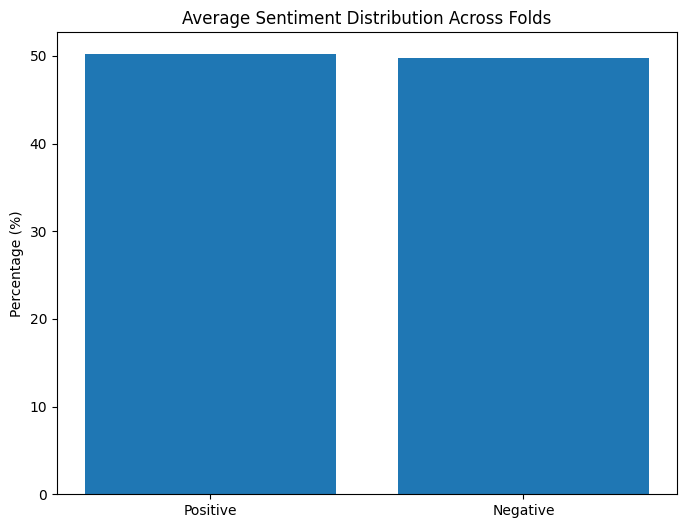

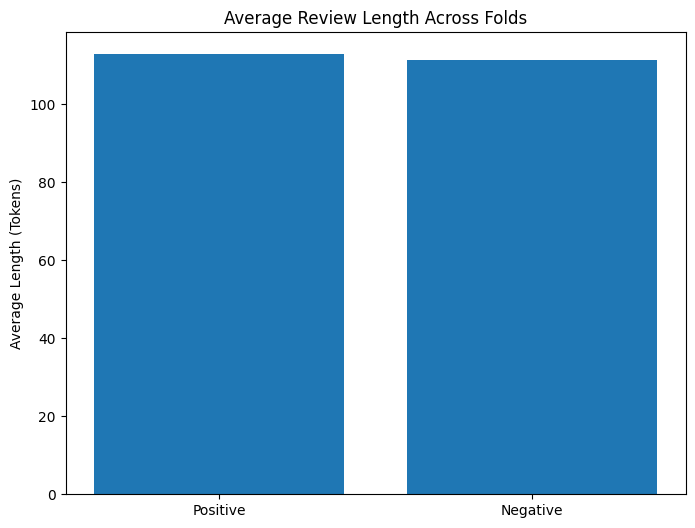

In [56]:
business_recommendations = []
if avg_test_accuracy > 0.85 and avg_test_roc_auc > 0.85:
    business_recommendations.append("Model memiliki akurasi dan ROC-AUC tinggi, sehingga dapat diandalkan untuk analisis sentimen otomatis dalam memprediksi ulasan film.")
    business_recommendations.append("Gunakan model ini untuk memantau sentimen audiens secara real-time pada platform ulasan untuk mendukung keputusan pemasaran.")
else:
    business_recommendations.append("Tingkatkan performa model dengan menambah data pelatihan atau menyesuaikan parameter seperti embed_dim atau num_layers untuk meningkatkan akurasi prediksi sentimen.")
if avg_positive_percentage > 60:
    business_recommendations.append("Mayoritas ulasan positif menunjukkan penerimaan yang baik dari audiens. Fokuskan kampanye pemasaran pada elemen film yang sering disebut dalam kata kunci positif.")
else:
    business_recommendations.append("Banyak ulasan negatif terdeteksi. Analisis kata kunci negatif untuk mengidentifikasi aspek film yang perlu diperbaiki, seperti alur cerita atau akting.")
business_recommendations.append("Gunakan kata kunci positif teratas untuk membangun narasi pemasaran yang menonjolkan kekuatan film.")
business_recommendations.append("Tindak lanjuti kata kunci negatif dengan analisis kualitatif untuk memahami keluhan audiens dan memperbaiki produksi film berikutnya.")
if avg_positive_length > avg_negative_length * 1.5:
    business_recommendations.append("Ulasan positif cenderung lebih panjang, menunjukkan audiens yang puas memberikan detail lebih banyak. Manfaatkan ulasan ini untuk testimoni mendalam.")
elif avg_negative_length > avg_positive_length * 1.5:
    business_recommendations.append("Ulasan negatif cenderung lebih panjang, menunjukkan audiens yang kecewa memberikan kritik lebih rinci. Prioritaskan analisis ulasan negatif untuk perbaikan.")

print("Business Recommendations:")
for i, rec in enumerate(business_recommendations, 1):
    print(f"{i}. {rec}")

plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [avg_positive_percentage, avg_negative_percentage])
plt.title('Average Sentiment Distribution Across Folds')
plt.ylabel('Percentage (%)')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [avg_positive_length, avg_negative_length])
plt.title('Average Review Length Across Folds')
plt.ylabel('Average Length (Tokens)')
plt.show()